# Imports

In [2]:
import os, os.path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imageio
from glob import glob
# from utils import *
import cv2
from scipy.ndimage import convolve
from mpl_toolkits.axes_grid1 import make_axes_locatable
from textwrap import wrap
from scipy.signal import sepfir2d
from IPython.display import clear_output
from time import sleep

import time

In [ ]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


# Set Up Files and File Names

In [ ]:
# Get All EO and SAR File Names
start_time = time.time()

rootdir = '../train_images'
# labels = [i for i in range(10)]

# Initialize filename lists
eo_filenames = []
sar_filenames = []

# Loop through all folder or labels
for i in range(10):
    path = rootdir + "/" + str(i)
    print(path)
    # for name in os.listdir(path):
    #     if os.path.isfile(os.path.join(path, name)) and name.startswith("EO"):
    #         eo_filenames[i].append(name)
    eo_filenames.append([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name)) and name.startswith("EO")])
    sar_filenames.append([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name)) and name.startswith("SAR")])
    
end_time = time.time()
print("Time to run cell:", end_time - start_time)

../train_images/0
../train_images/1
../train_images/2
../train_images/3
../train_images/4
../train_images/5
../train_images/6
../train_images/7
../train_images/8
../train_images/9
Time to run cell: 26.284765005111694


In [ ]:
# Sort filenames of EO and SAR images so we can access them through the same index
for i in range(10):
    eo_filenames[i].sort()
    sar_filenames[i].sort()


In [ ]:
# Check if they are sorted
print(eo_filenames[3][:10])
print(sar_filenames[3][:10])

['EO_100040.png', 'EO_100043.png', 'EO_100123.png', 'EO_100126.png', 'EO_100159.png', 'EO_100164.png', 'EO_100178.png', 'EO_100203.png', 'EO_100225.png', 'EO_100270.png']
['SAR_100040.png', 'SAR_100043.png', 'SAR_100123.png', 'SAR_100126.png', 'SAR_100159.png', 'SAR_100164.png', 'SAR_100178.png', 'SAR_100203.png', 'SAR_100225.png', 'SAR_100270.png']


In [ ]:
# Load Label Names
labels = ['sedan', # 0
          'suv', # 1
          'pickup truck', # 2
          'van', # 3
          'box truck', # 4
          'motorcycle', # 5
          'flatbed truck', # 6
          'bus', # 7
          'pickup truck with trailer', # 8
          'flatbed truck with trailer', # 9
         ]

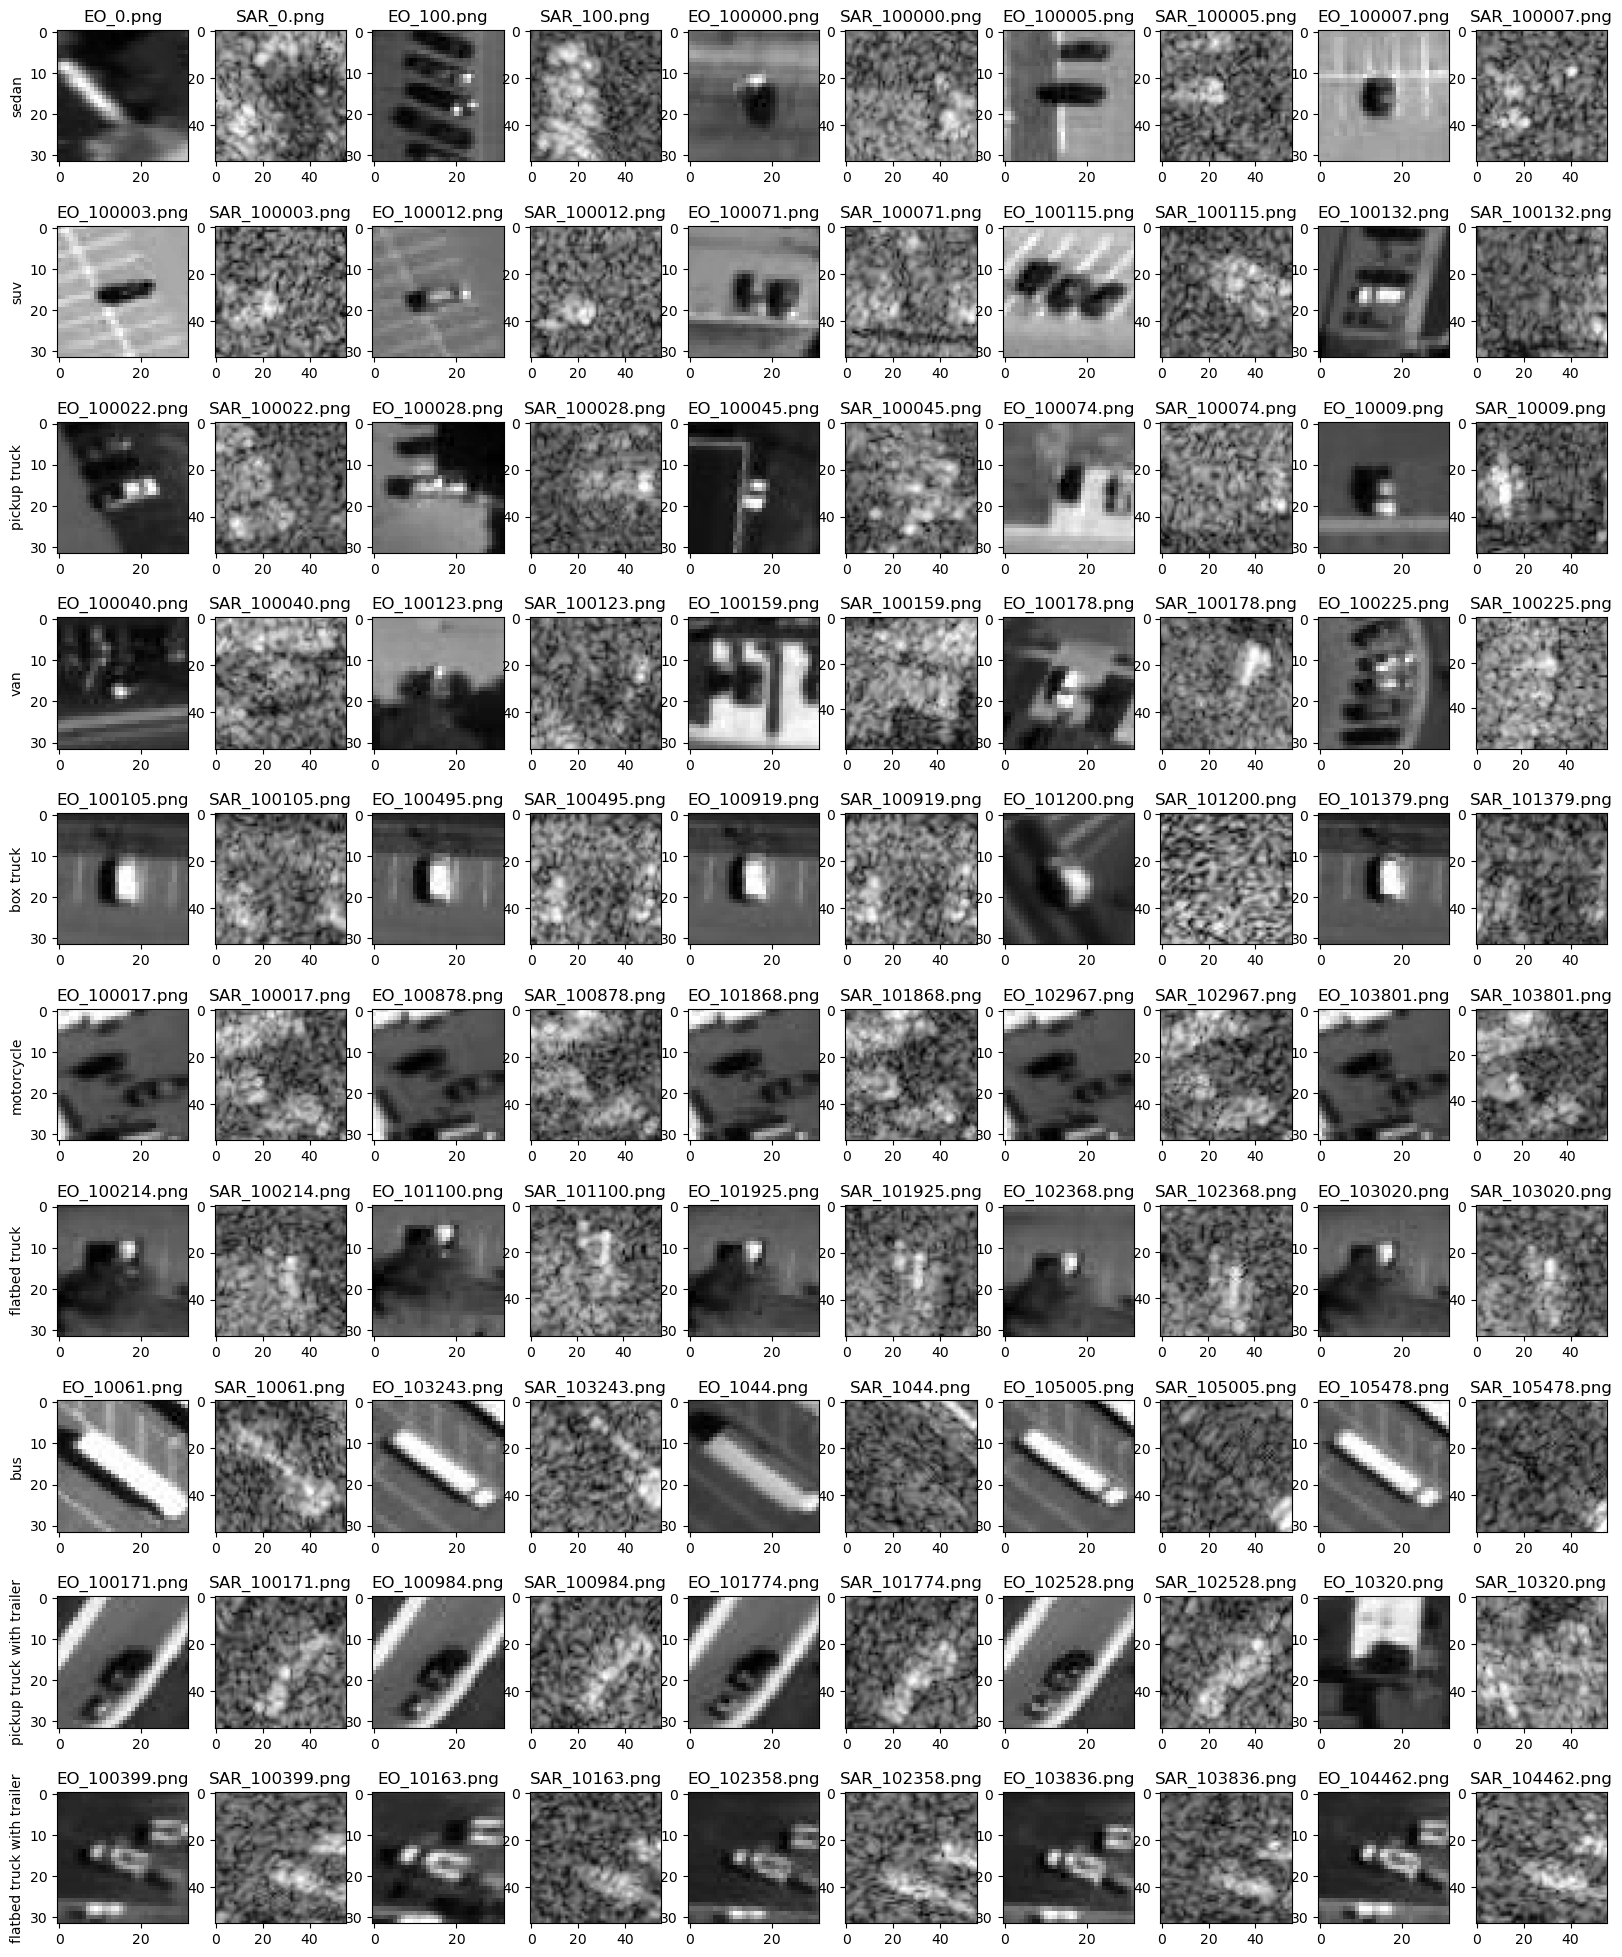

In [ ]:
# Open side-by-side the first 5 images for EO and SAR images for all labels

fig, ax = plt.subplots(10, 10, figsize=(20,25))

# For all labels
for i in range(10):
    # For a sample of 5 images
    for j in range(0,10,2):
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][j] 
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Displaying the images
        ax[i][j].imshow(img_eo, cmap='gray')
        ax[i][j].set_title(eo_filenames[i][j])
        ax[i][j+1].imshow(img_sar, cmap='gray')
        ax[i][j+1].set_title(sar_filenames[i][j])
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()

# Data Exploration

In [ ]:
# Checks that all EO and SAR images are represented in training set 

# rootdir = '../train_images'
# total_eo_files = 0
# total_sar_files = 0
# for file in os.listdir(rootdir):
#     d = os.path.join(rootdir, file)
#     if os.path.isdir(d):
#         eo_num_files = len([name for name in os.listdir(d) if os.path.isfile(os.path.join(d, name)) and name.startswith("EO")])
#         sar_num_files = len([name for name in os.listdir(d) if os.path.isfile(os.path.join(d, name)) and name.startswith("SAR")])
#         print("Directory %s (EO): %d" %(d, eo_num_files))
#         print("Directory %s (SAR): %d" %(d, sar_num_files))
#         total_eo_files += eo_num_files
#         total_sar_files += sar_num_files
# print(total_eo_files)
# print(total_sar_files)

Directory ../train_images/9 (EO): 633
Directory ../train_images/9 (SAR): 633
Directory ../train_images/0 (EO): 234209
Directory ../train_images/0 (SAR): 234209
Directory ../train_images/7 (EO): 624
Directory ../train_images/7 (SAR): 624
Directory ../train_images/6 (EO): 828
Directory ../train_images/6 (SAR): 828
Directory ../train_images/1 (EO): 28089
Directory ../train_images/1 (SAR): 28089
Directory ../train_images/8 (EO): 840
Directory ../train_images/8 (SAR): 840
Directory ../train_images/4 (EO): 1741
Directory ../train_images/4 (SAR): 1741
Directory ../train_images/3 (EO): 10655
Directory ../train_images/3 (SAR): 10655
Directory ../train_images/2 (EO): 15301
Directory ../train_images/2 (SAR): 15301
Directory ../train_images/5 (EO): 852
Directory ../train_images/5 (SAR): 852
293772
293772


## Mean signal levels

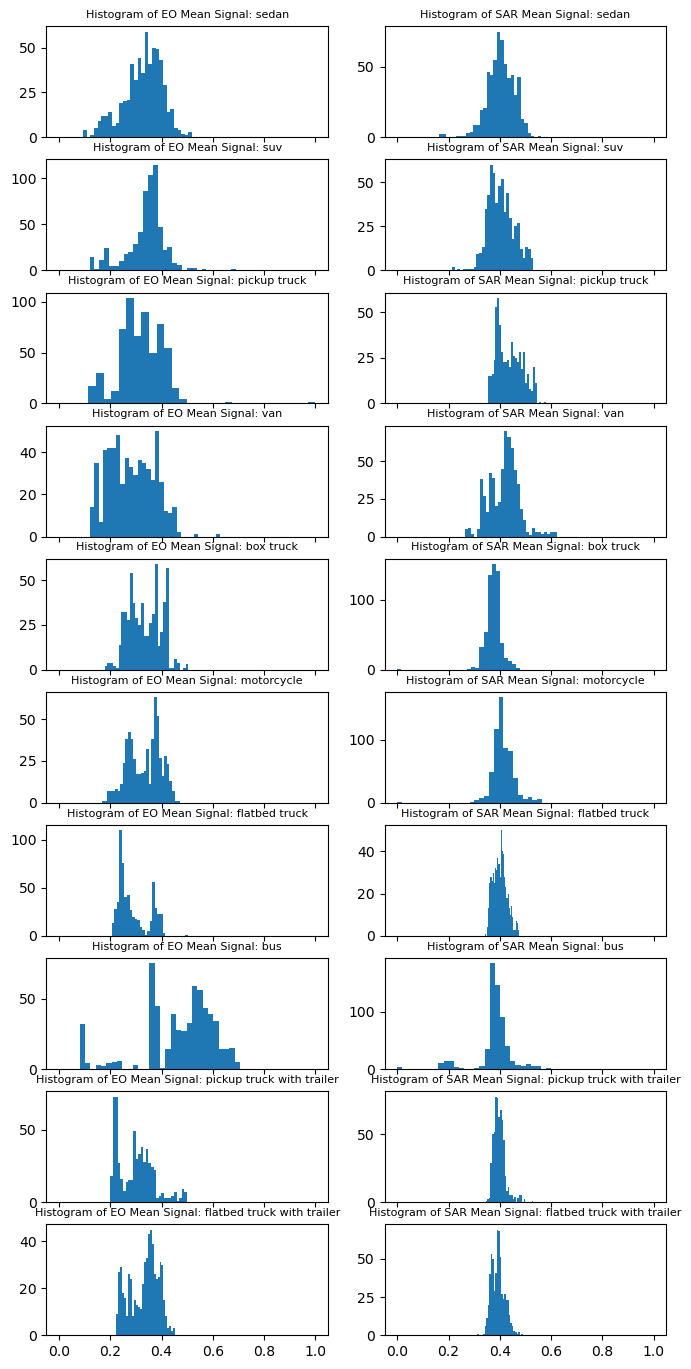

In [ ]:
# Checks overall mean signal levels for first "num_images" images for each image across labels
num_images = 600

mean_eo_signals = np.zeros((10,num_images))
mean_sar_signals = np.zeros((10,num_images))

for i in range(10): # For all labels
    for j in range(num_images): # 
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][j] 
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Get mean for the image
        mean_eo_signals[i,j] = np.mean(img_eo)
        mean_sar_signals[i,j] = np.mean(img_sar)

# Plot distribution of mean signals for 200 images of each label
fig, ax = plt.subplots(10, 2, figsize=(8,17), sharex=True)

for i in range(10):
    ax[i][0].hist(mean_eo_signals[i], bins=30)
    ax[i][0].set_title("Histogram of EO Mean Signal: " + labels[i], fontsize=8)
    ax[i][1].hist(mean_sar_signals[i], bins=30)
    ax[i][1].set_title("Histogram of SAR Mean Signal: " + labels[i], fontsize=8)
        
plt.show()

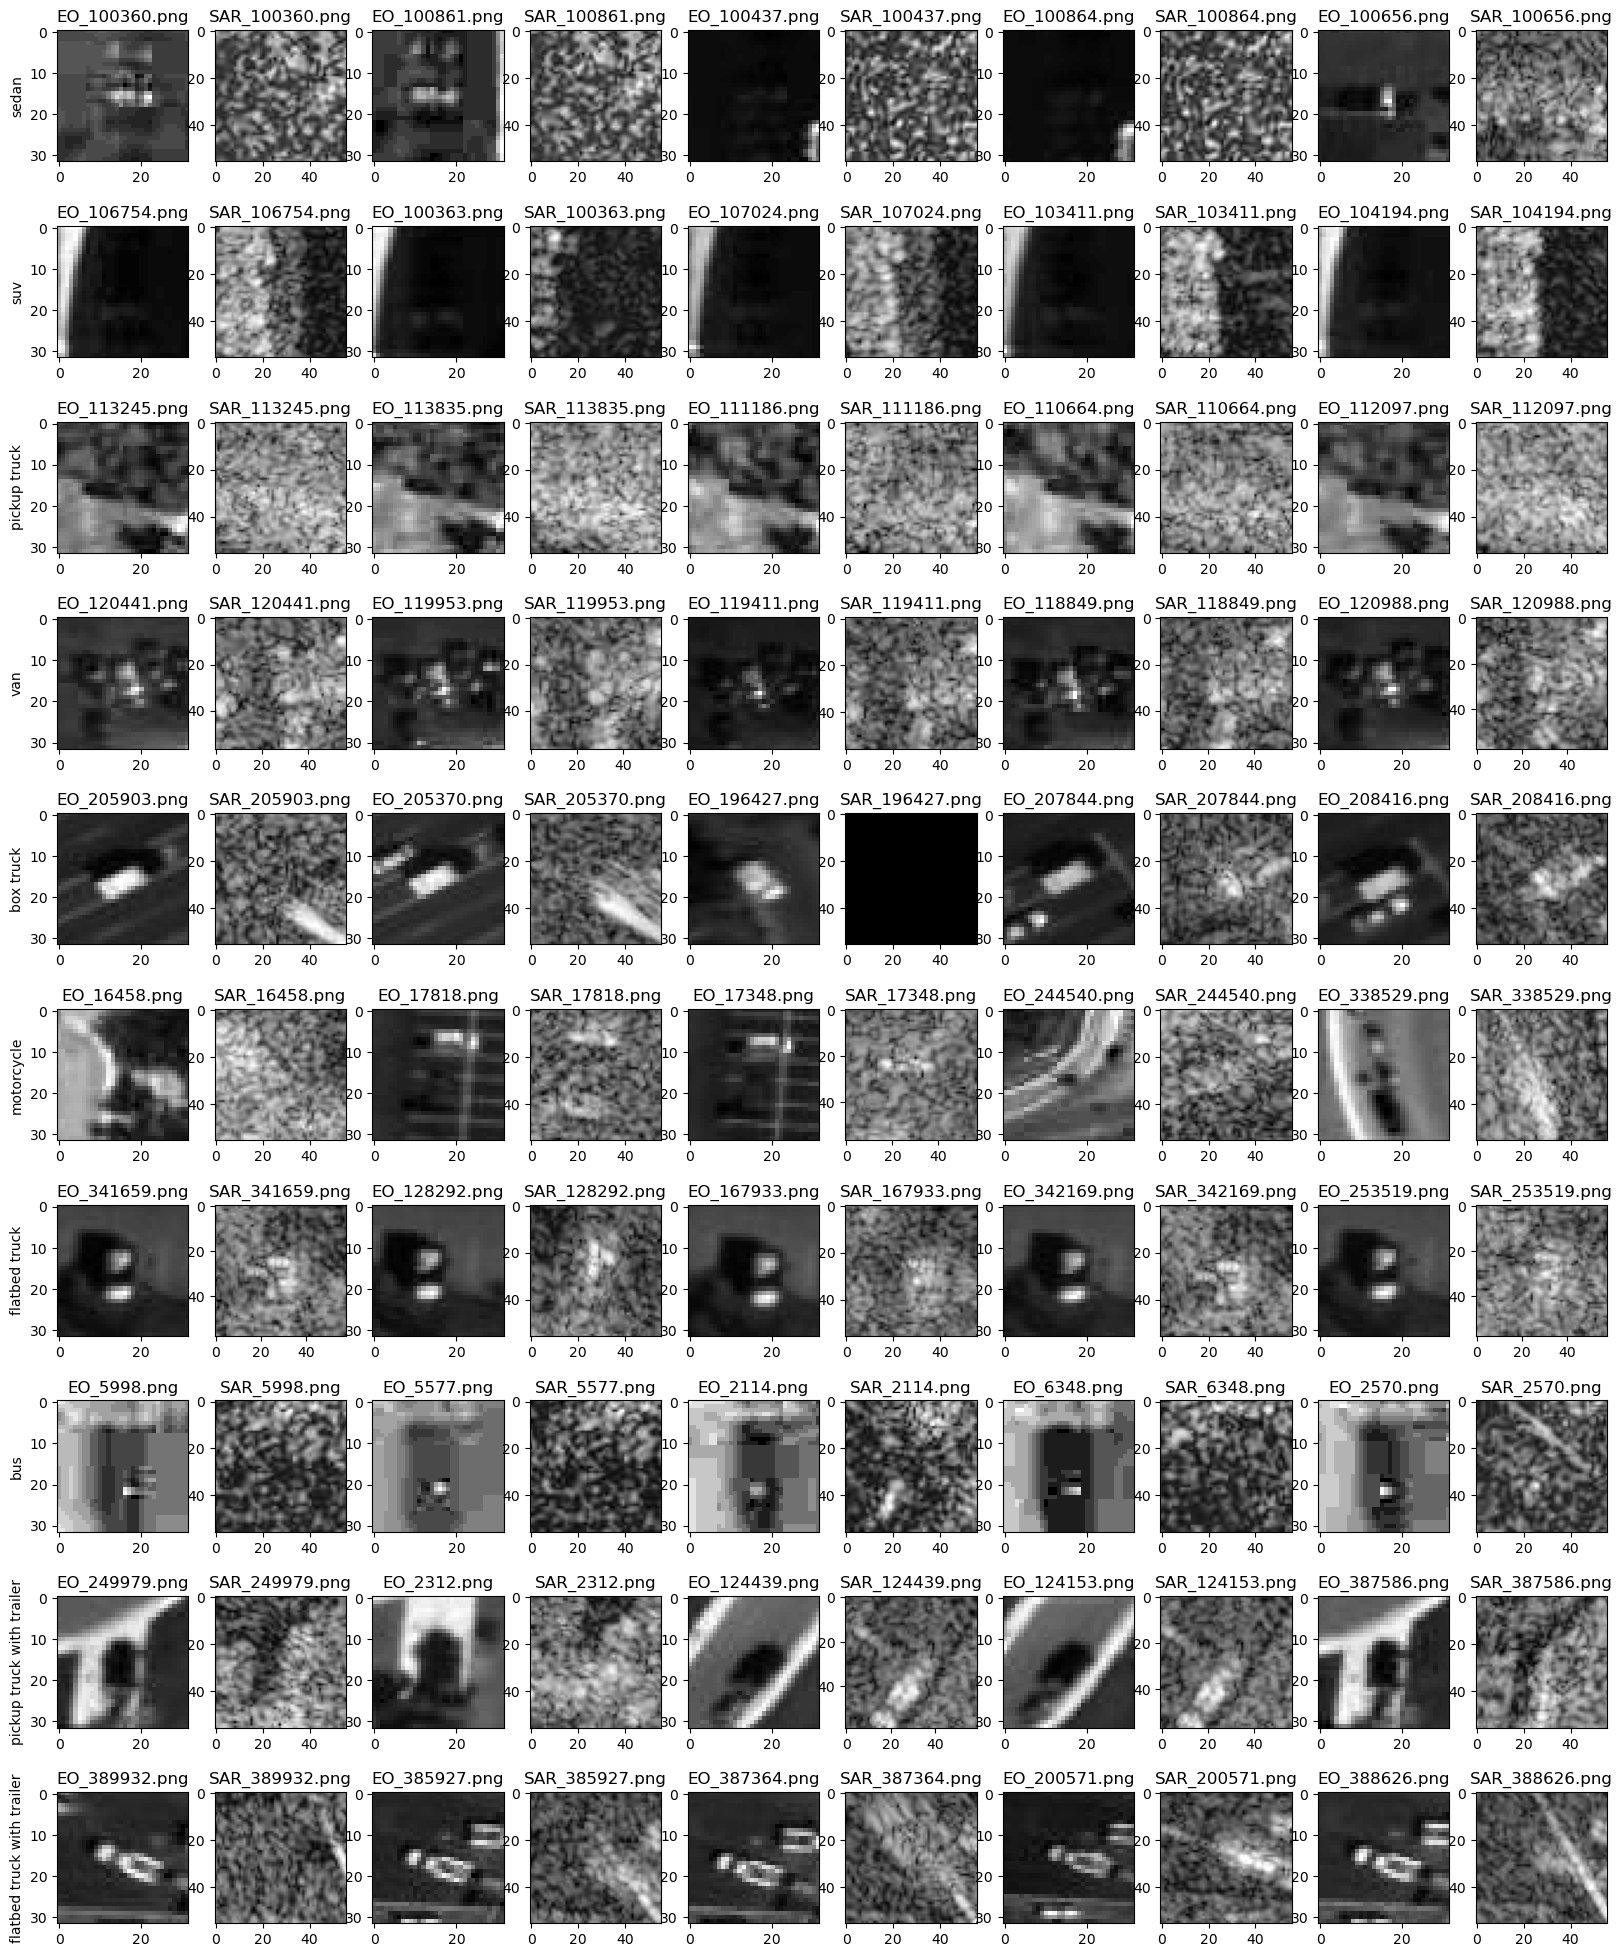

In [ ]:
# Plot the lowest mean signal images for num_images number of images

ind = np.argsort(mean_eo_signals, axis=1)

eo_filenames[0][ind[0][0]] 

num_images = 5

fig, ax = plt.subplots(10, 2*num_images, figsize=(20,25))
for i in range(10): # For all labels
    for j in range(num_images): # 
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][ind[i][j]]  
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][ind[i][j]] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)

        # Displaying the image
        ax[i][j*2].imshow(img_eo, cmap='gray')
        ax[i][j*2].set_title(eo_filenames[i][ind[i][j]])
        ax[i][j*2+1].imshow(img_sar, cmap='gray')
        ax[i][j*2+1].set_title(sar_filenames[i][ind[i][j]])
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()


In [ ]:
# To Do: Review the EO images with low mean signals to see if quality is low (and should replace with SAR)

## Standard Deviations

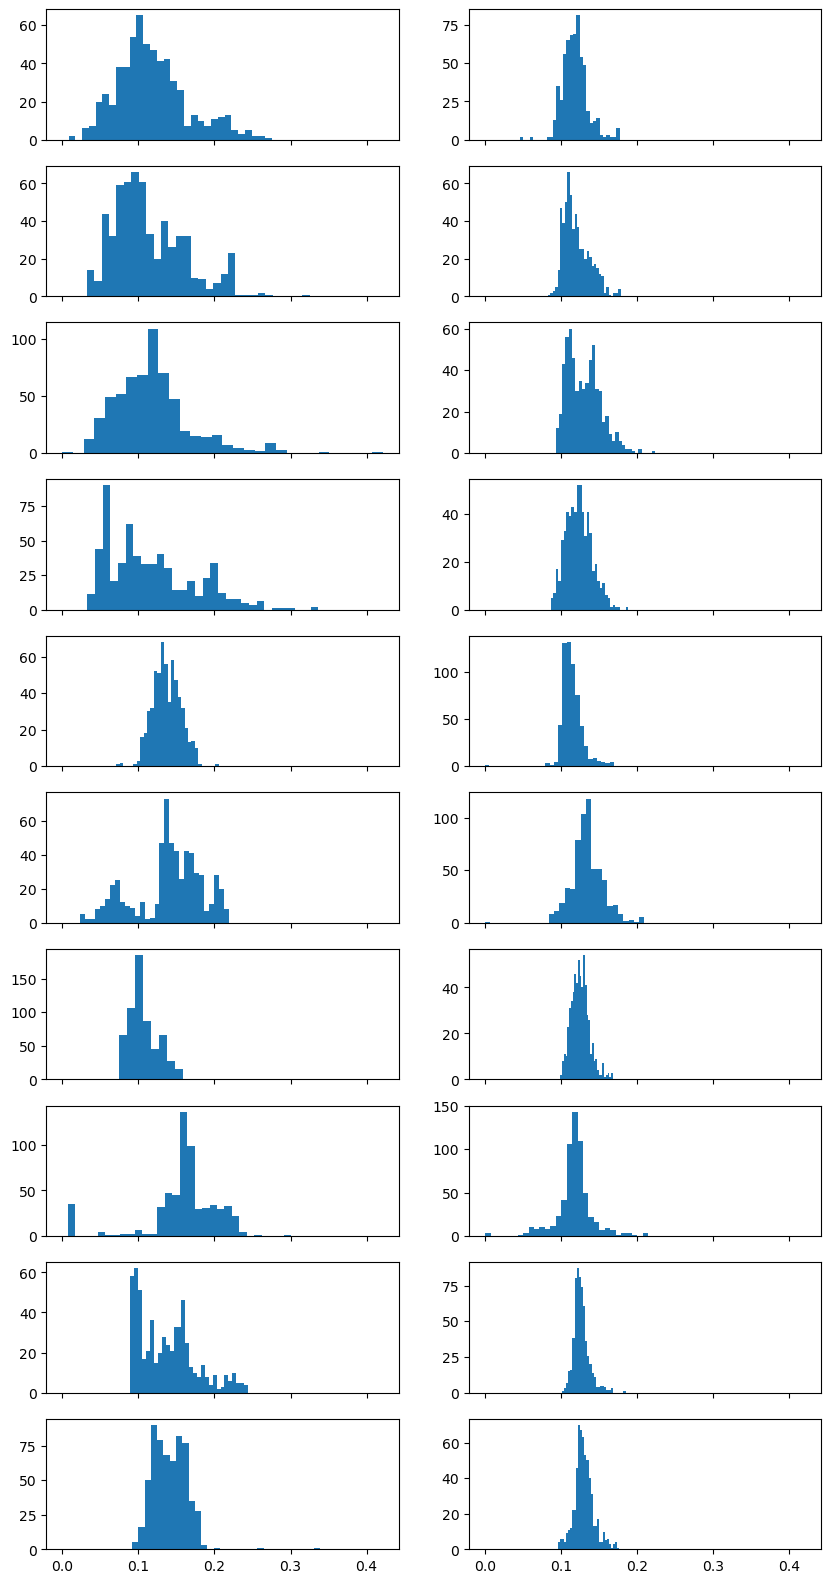

In [ ]:
# Checks standard deviations for first "num_images" images for each image across labels
num_images = 600

std_eo_signals = np.zeros((10,num_images))
std_sar_signals = np.zeros((10,num_images))

for i in range(10): # For all labels
    for j in range(num_images): # 
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][j] 
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Get mean for the image
        std_eo_signals[i,j] = np.std(img_eo)
        std_sar_signals[i,j] = np.std(img_sar)

# Plot distribution of mean signals for 200 images of each label
fig, ax = plt.subplots(10, 2, figsize=(8,17), sharex=True)

for i in range(10):
    ax[i][0].hist(std_eo_signals[i], bins=30)
    ax[i][1].hist(std_sar_signals[i], bins=30)
        
plt.show()

0.008086783811450005
0.0932636484503746


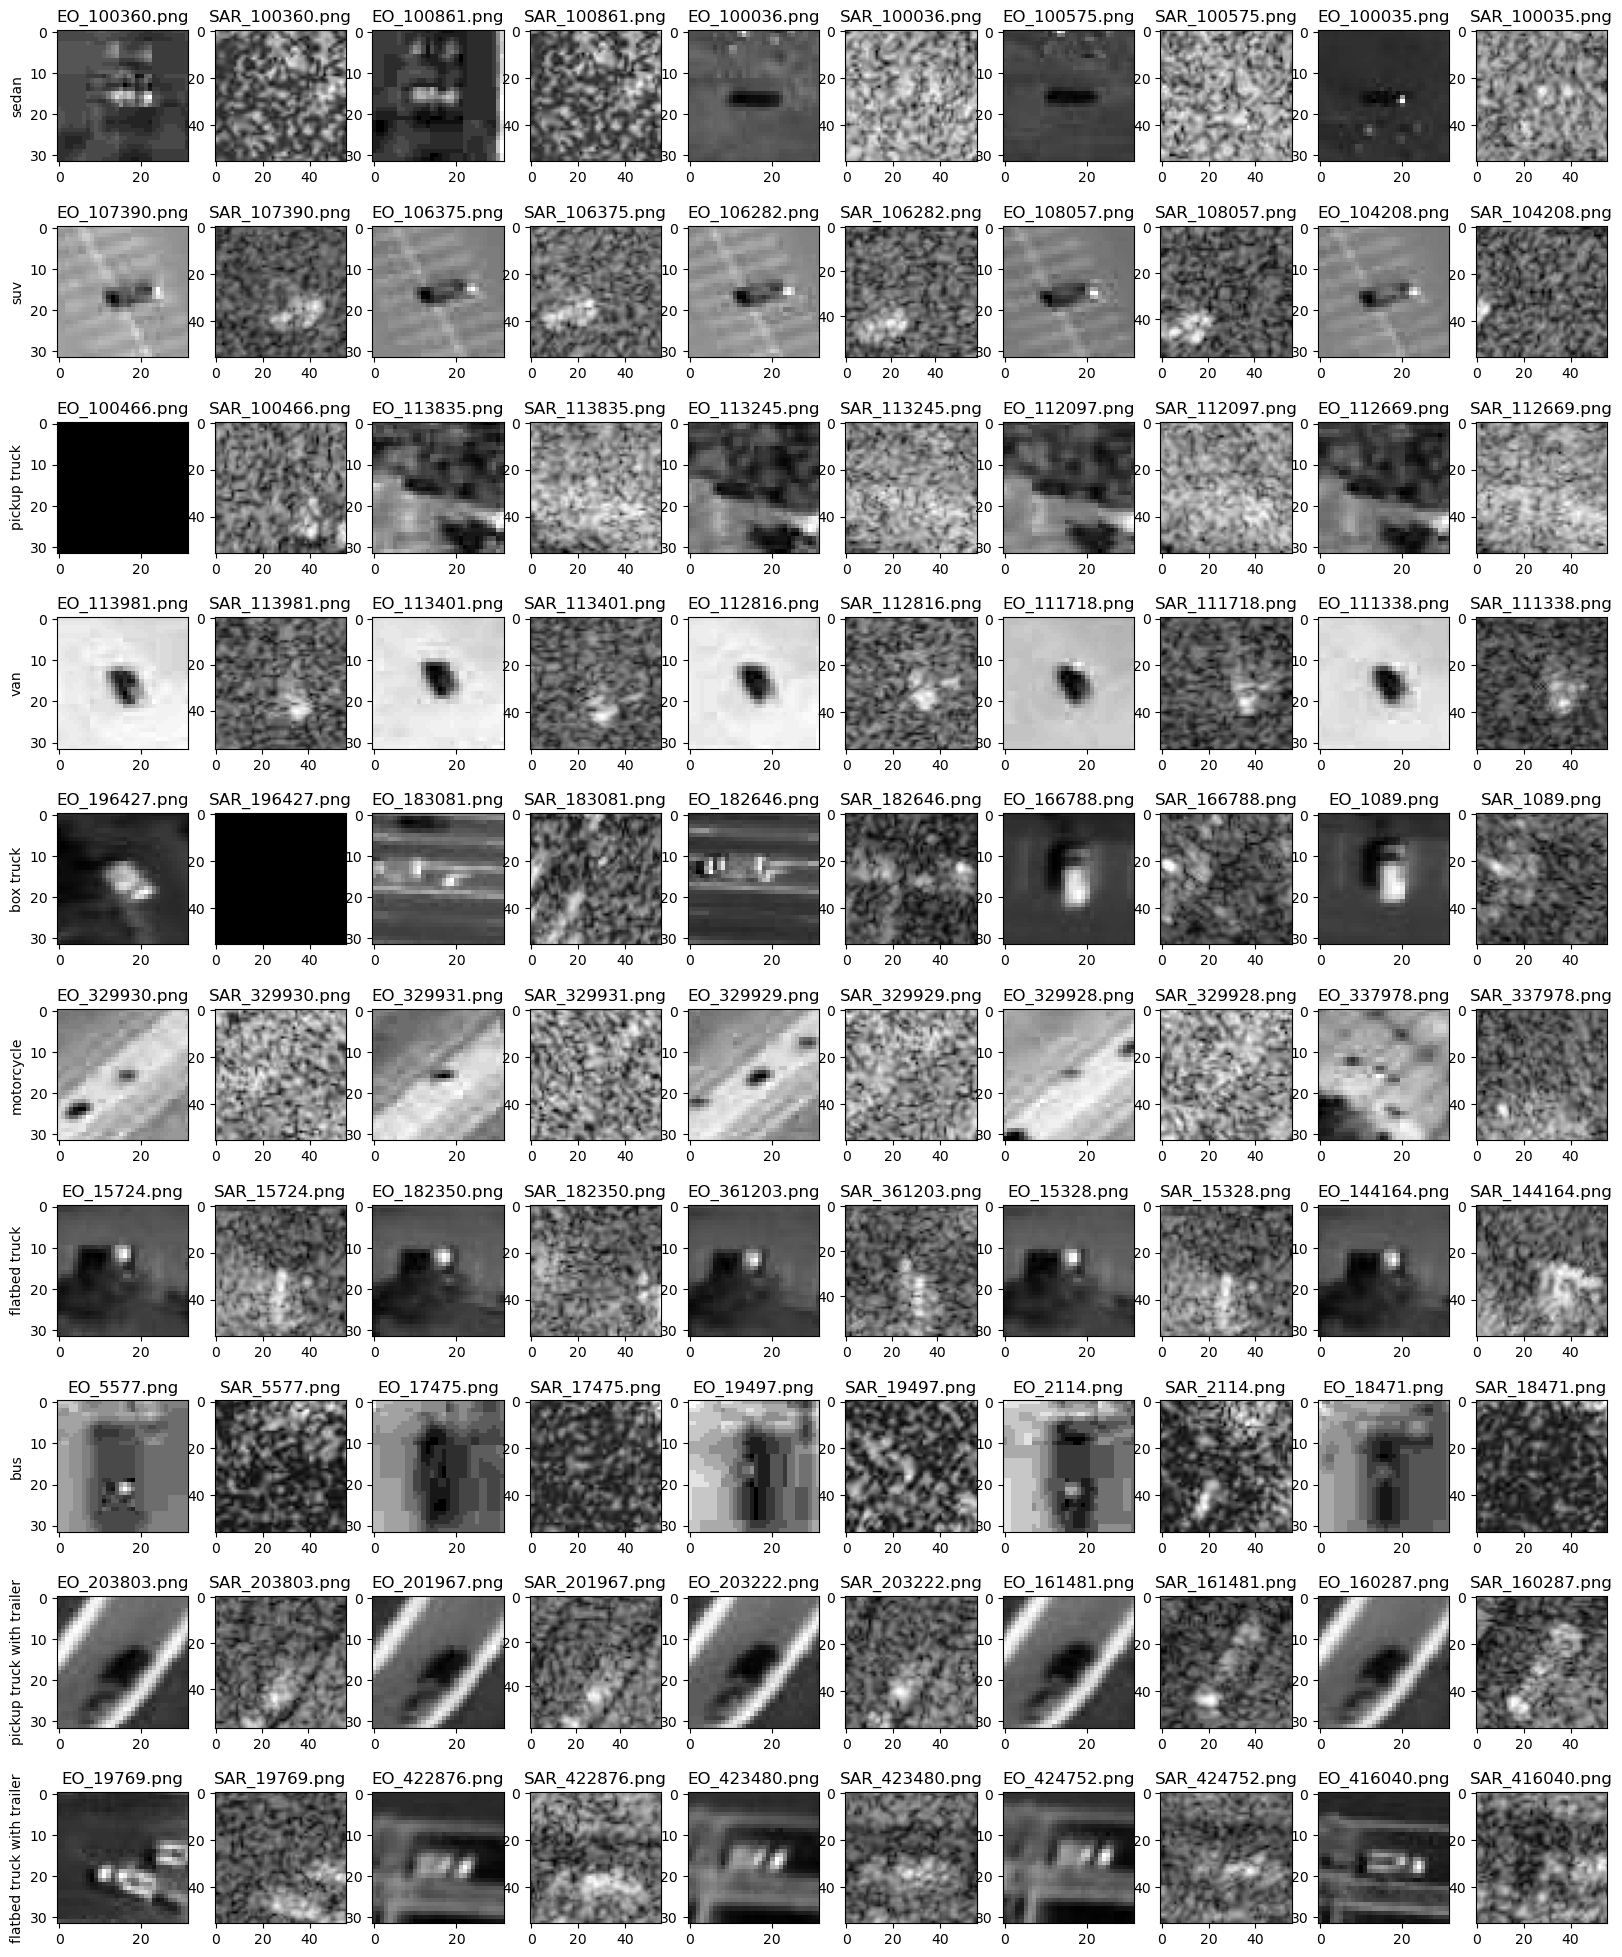

In [ ]:
ind2 = np.argsort(std_eo_signals, axis=1)
print(std_eo_signals[0][ind2[0][0]])
print(mean_eo_signals[0][ind2[0][0]])
# Plot lowest std deviation images
num_images = 5

fig, ax = plt.subplots(10, 2*num_images, figsize=(20,25))
for i in range(10): # For all labels
    for j in range(num_images): # 
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][ind2[i][j]]  
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][ind2[i][j]] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)

        # Displaying the image
        ax[i][j*2].imshow(img_eo, cmap='gray')
        ax[i][j*2].set_title(eo_filenames[i][ind2[i][j]])
        ax[i][j*2+1].imshow(img_sar, cmap='gray')
        ax[i][j*2+1].set_title(sar_filenames[i][ind2[i][j]])
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()


0.026272539049386978
0.0932636484503746


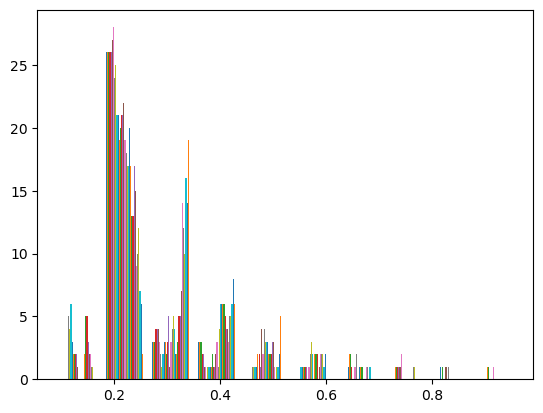

In [ ]:
print(std_eo_signals[0][ind2[0][2]])
print(mean_eo_signals[0][ind2[0][0]])
ind2[0][0]
path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][ind2[0][0]]  
path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][ind2[0][0]] 

# Read images
img_eo = plt.imread(path_eo)
img_sar = plt.imread(path_sar)

# Displaying the image
# plt.imshow(img_eo, cmap='gray')
plt.hist(img_eo)
# ax[i][j*2].set_title(eo_filenames[i][ind[i][j]])
plt.show()

## Maximum signal levels

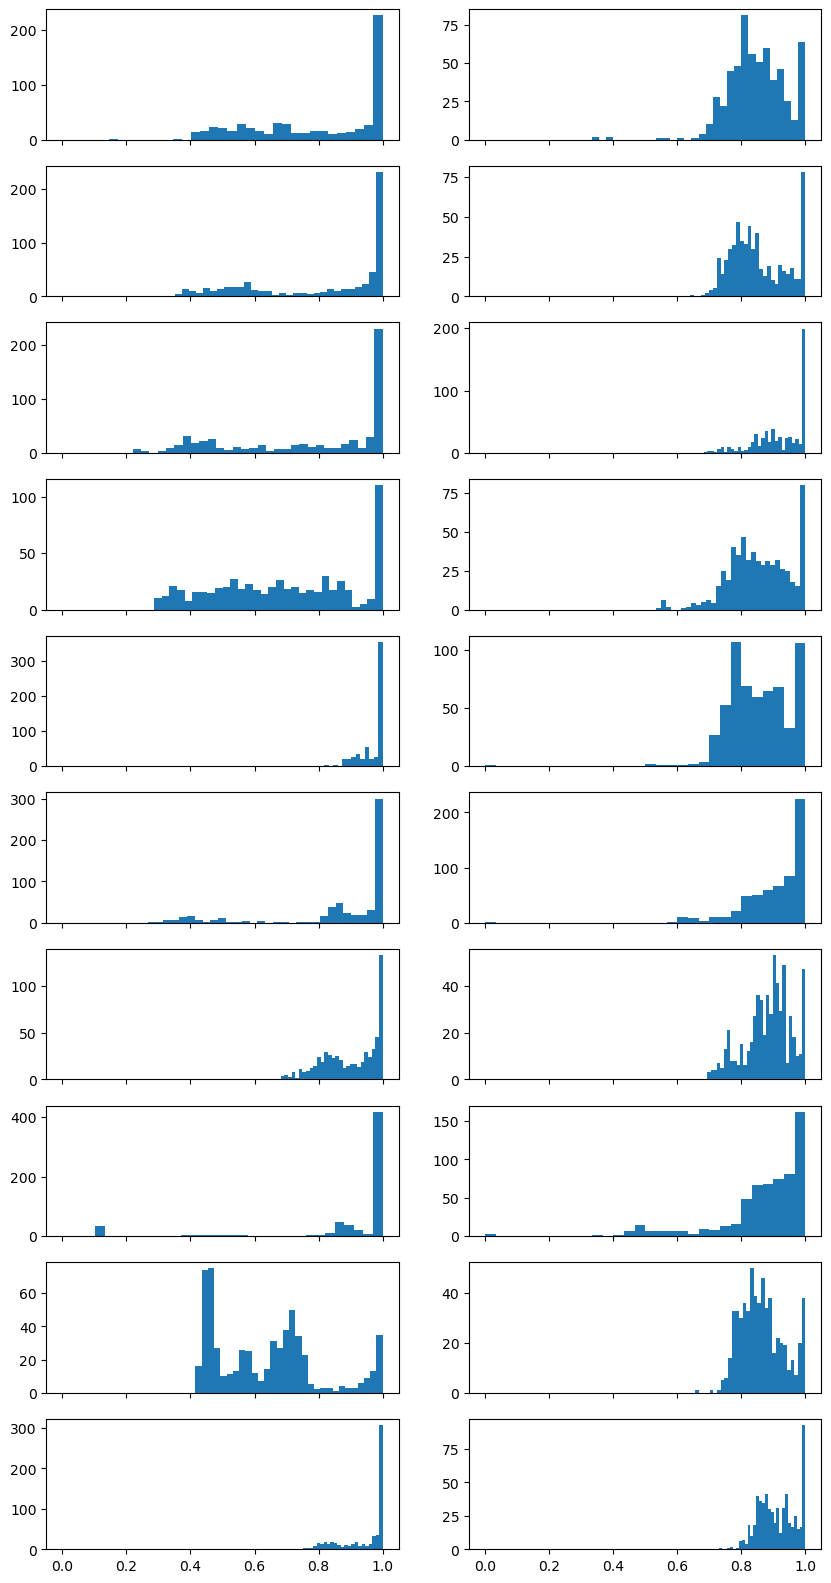

In [ ]:
# Checks max value for first "num_images" images for each image across labels
num_images = 600

max_eo_signals = np.zeros((10,num_images))
max_sar_signals = np.zeros((10,num_images))

for i in range(10): # For all labels
    for j in range(num_images): # 
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][j] 
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        # Get max for the image
        max_eo_signals[i,j] = img_eo.max()
        max_sar_signals[i,j] = img_sar.max()

# Plot distribution of mean signals for 200 images of each label
fig, ax = plt.subplots(10, 2, figsize=(10,20), sharex=True)

for i in range(10):
    ax[i][0].hist(max_eo_signals[i], bins=30)
    ax[i][1].hist(max_sar_signals[i], bins=30)
        
plt.show()

0.14509804546833038
0.0
0.0942784994840622


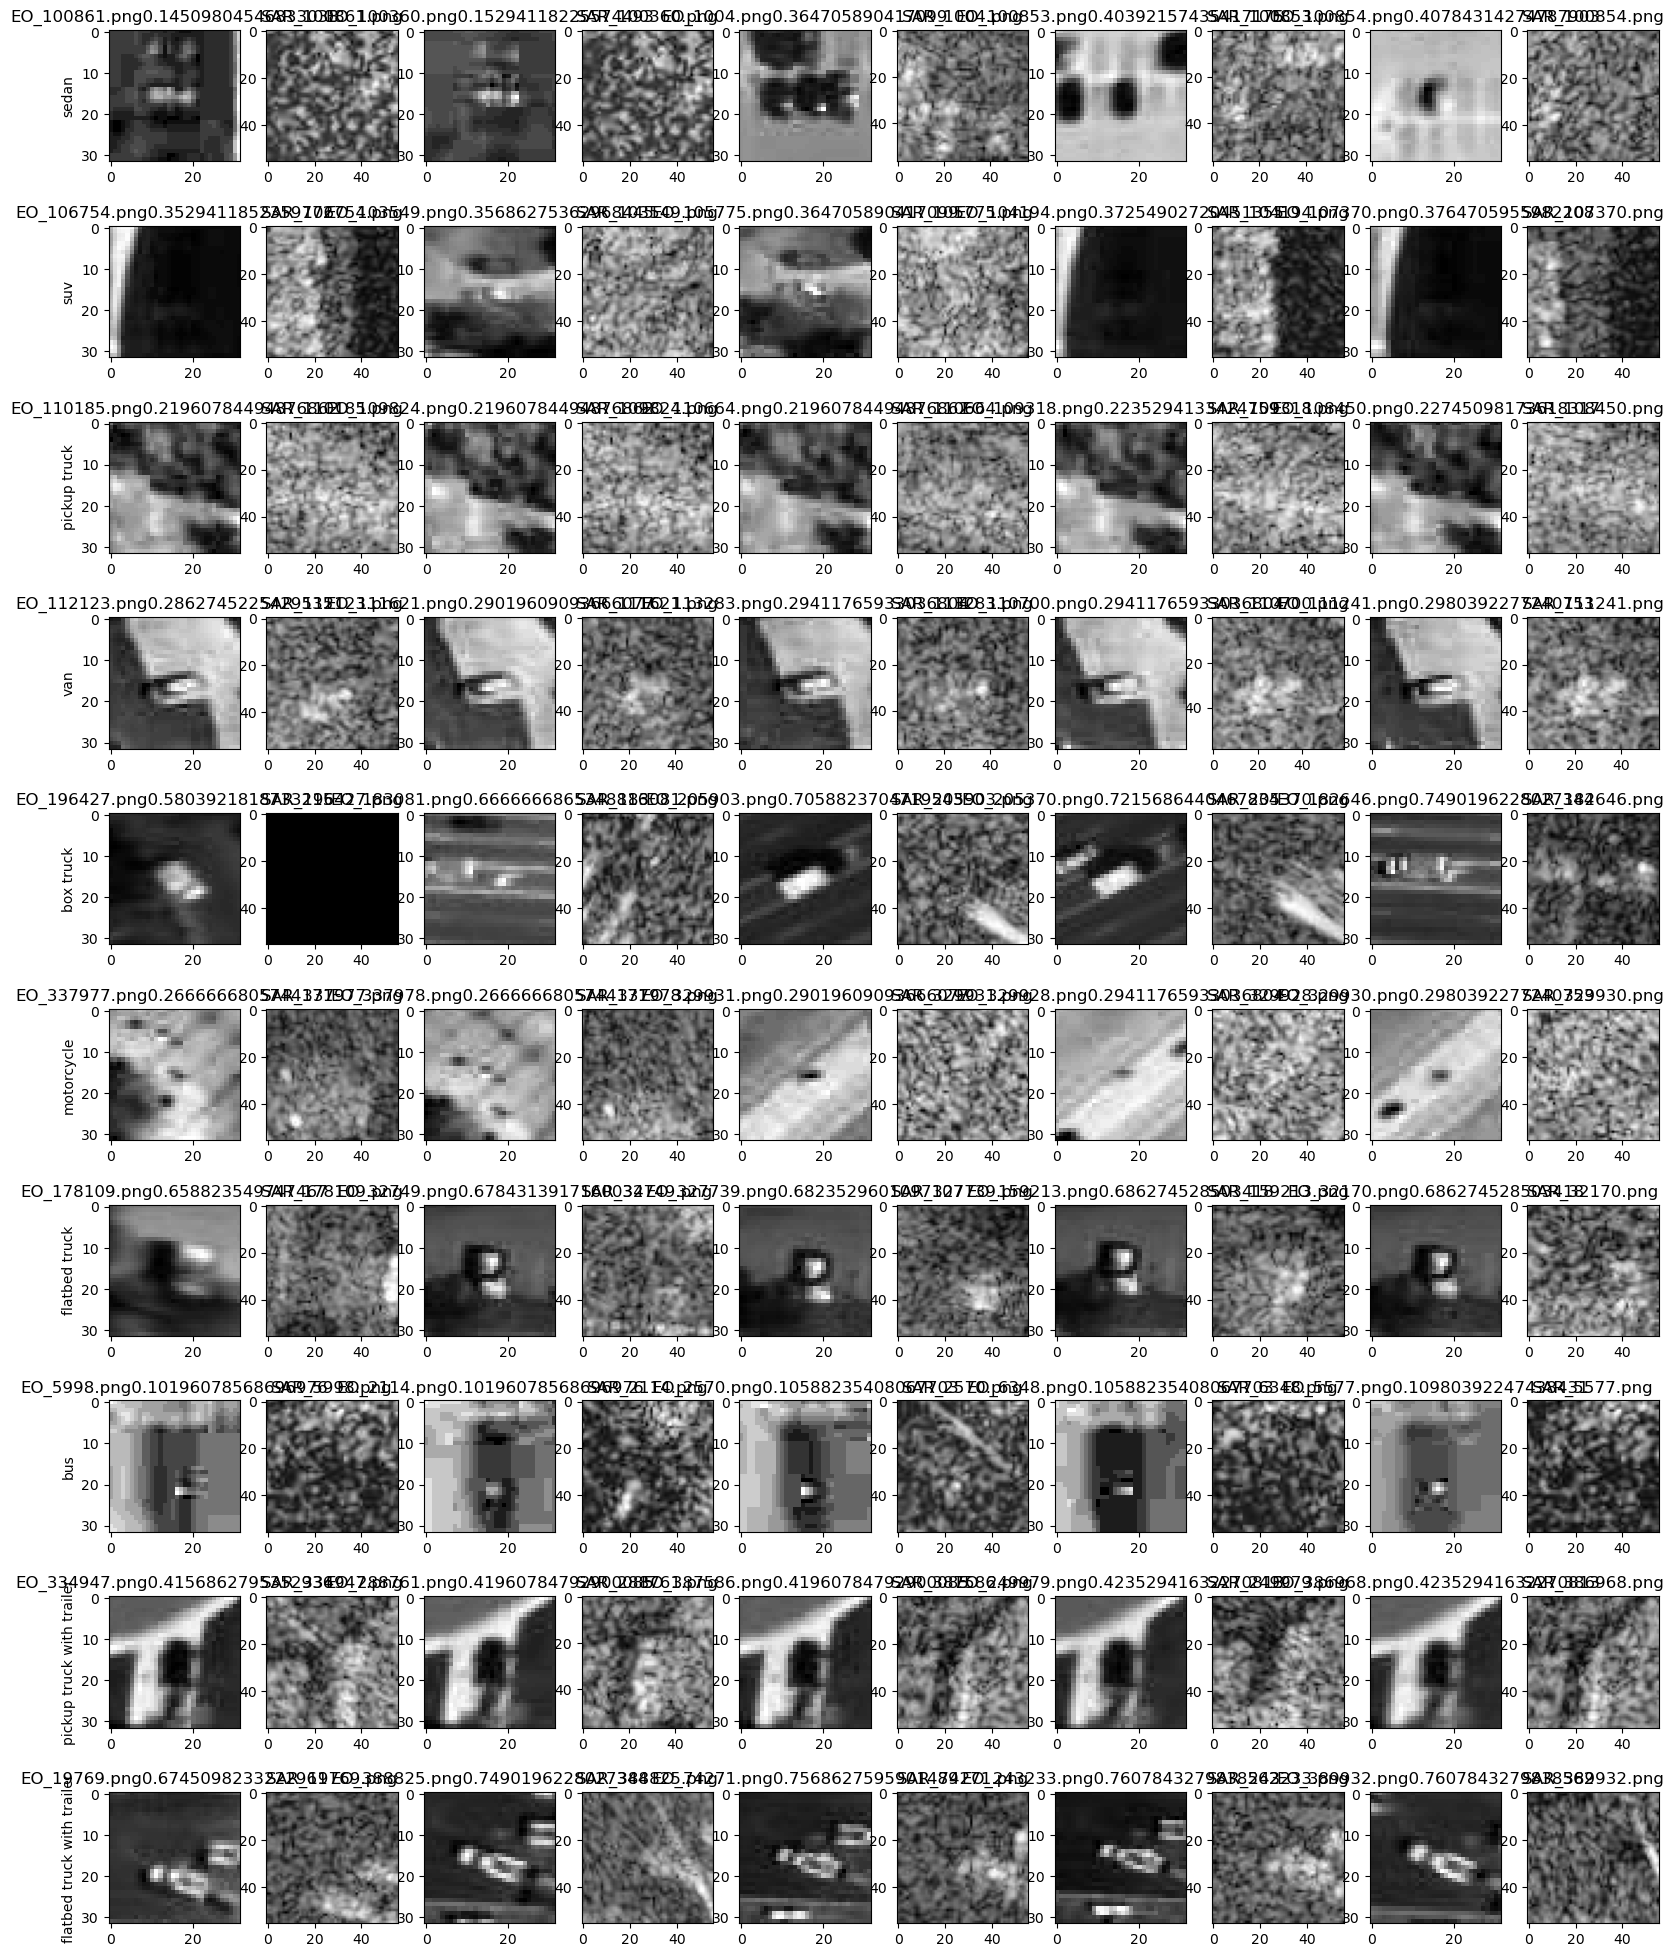

In [ ]:
ind3 = np.argsort(max_eo_signals, axis=1)
print(max_eo_signals[0][ind3[0][0]])
print(std_eo_signals[0][ind3[0][0]])
print(mean_eo_signals[0][ind3[0][0]])
# Plot lowest std deviation images
num_images = 5

fig, ax = plt.subplots(10, 2*num_images, figsize=(20,25))
for i in range(10): # For all labels
    for j in range(num_images): # 
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][ind3[i][j]]  
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][ind3[i][j]] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)

        # Displaying the image
        ax[i][j*2].imshow(img_eo, cmap='gray')
        ax[i][j*2].set_title(eo_filenames[i][ind3[i][j]] + str(max_eo_signals[i][ind3[i][j]]))
        ax[i][j*2+1].imshow(img_sar, cmap='gray')
        ax[i][j*2+1].set_title(sar_filenames[i][ind3[i][j]])
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()


In [ ]:

ind3 = np.argsort(max_eo_signals, axis=1)
max_eo_signals[2][ind3[2][2]]

0.21960784494876862

# Feature Extraction

## Create Gaussian Filters

In [ ]:
from scipy import signal
import numpy as np

""" create a 2-D gaussian blurr filter for a given mean and std """
def create_2d_gaussian(size=9, std=1.5):
    gaussian_1d = signal.gaussian(size,std=std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    gaussian_2d = gaussian_2d/(gaussian_2d.sum())
    return gaussian_2d


""" normalize teh image between 0 and 1 """
def normalize_img(img):
    normalized = (img - img.min())/(img.max() - img.min())    
    return normalized

In [ ]:
# create a function that takes in an two images,  
# uses the create_2d_gaussian method inside the utils script to create a 2D Gaussian filter
# then passes these filters to scipy.ndimage's convolve function
# finally, uses these blurred images to return a hybrid image

def hp_filter(im, size=15, std=7):
    # Create filters
    lp = create_2d_gaussian(size=size, std=std)
    imp = np.zeros((size,size))
    imp[int(size/2),int(size/2)] = 1
    hp = imp - lp
    
    # Convolve im2 with high pass filter
    out = convolve(im, hp)
    
    return out

def lp_filter(im, size=15, std=7):
    # Create filters
    lp = create_2d_gaussian(size=size, std=std)
    imp = np.zeros((size,size))
    imp[int(size/2),int(size/2)] = 1
    hp = imp - lp
    
    # Convolve images with filters
    # Convolve im1 with low pass filter
    out = convolve(im, lp)
    
    return out

## Noise Reduction (particularly on SAR)
1. Low Pass Filtering

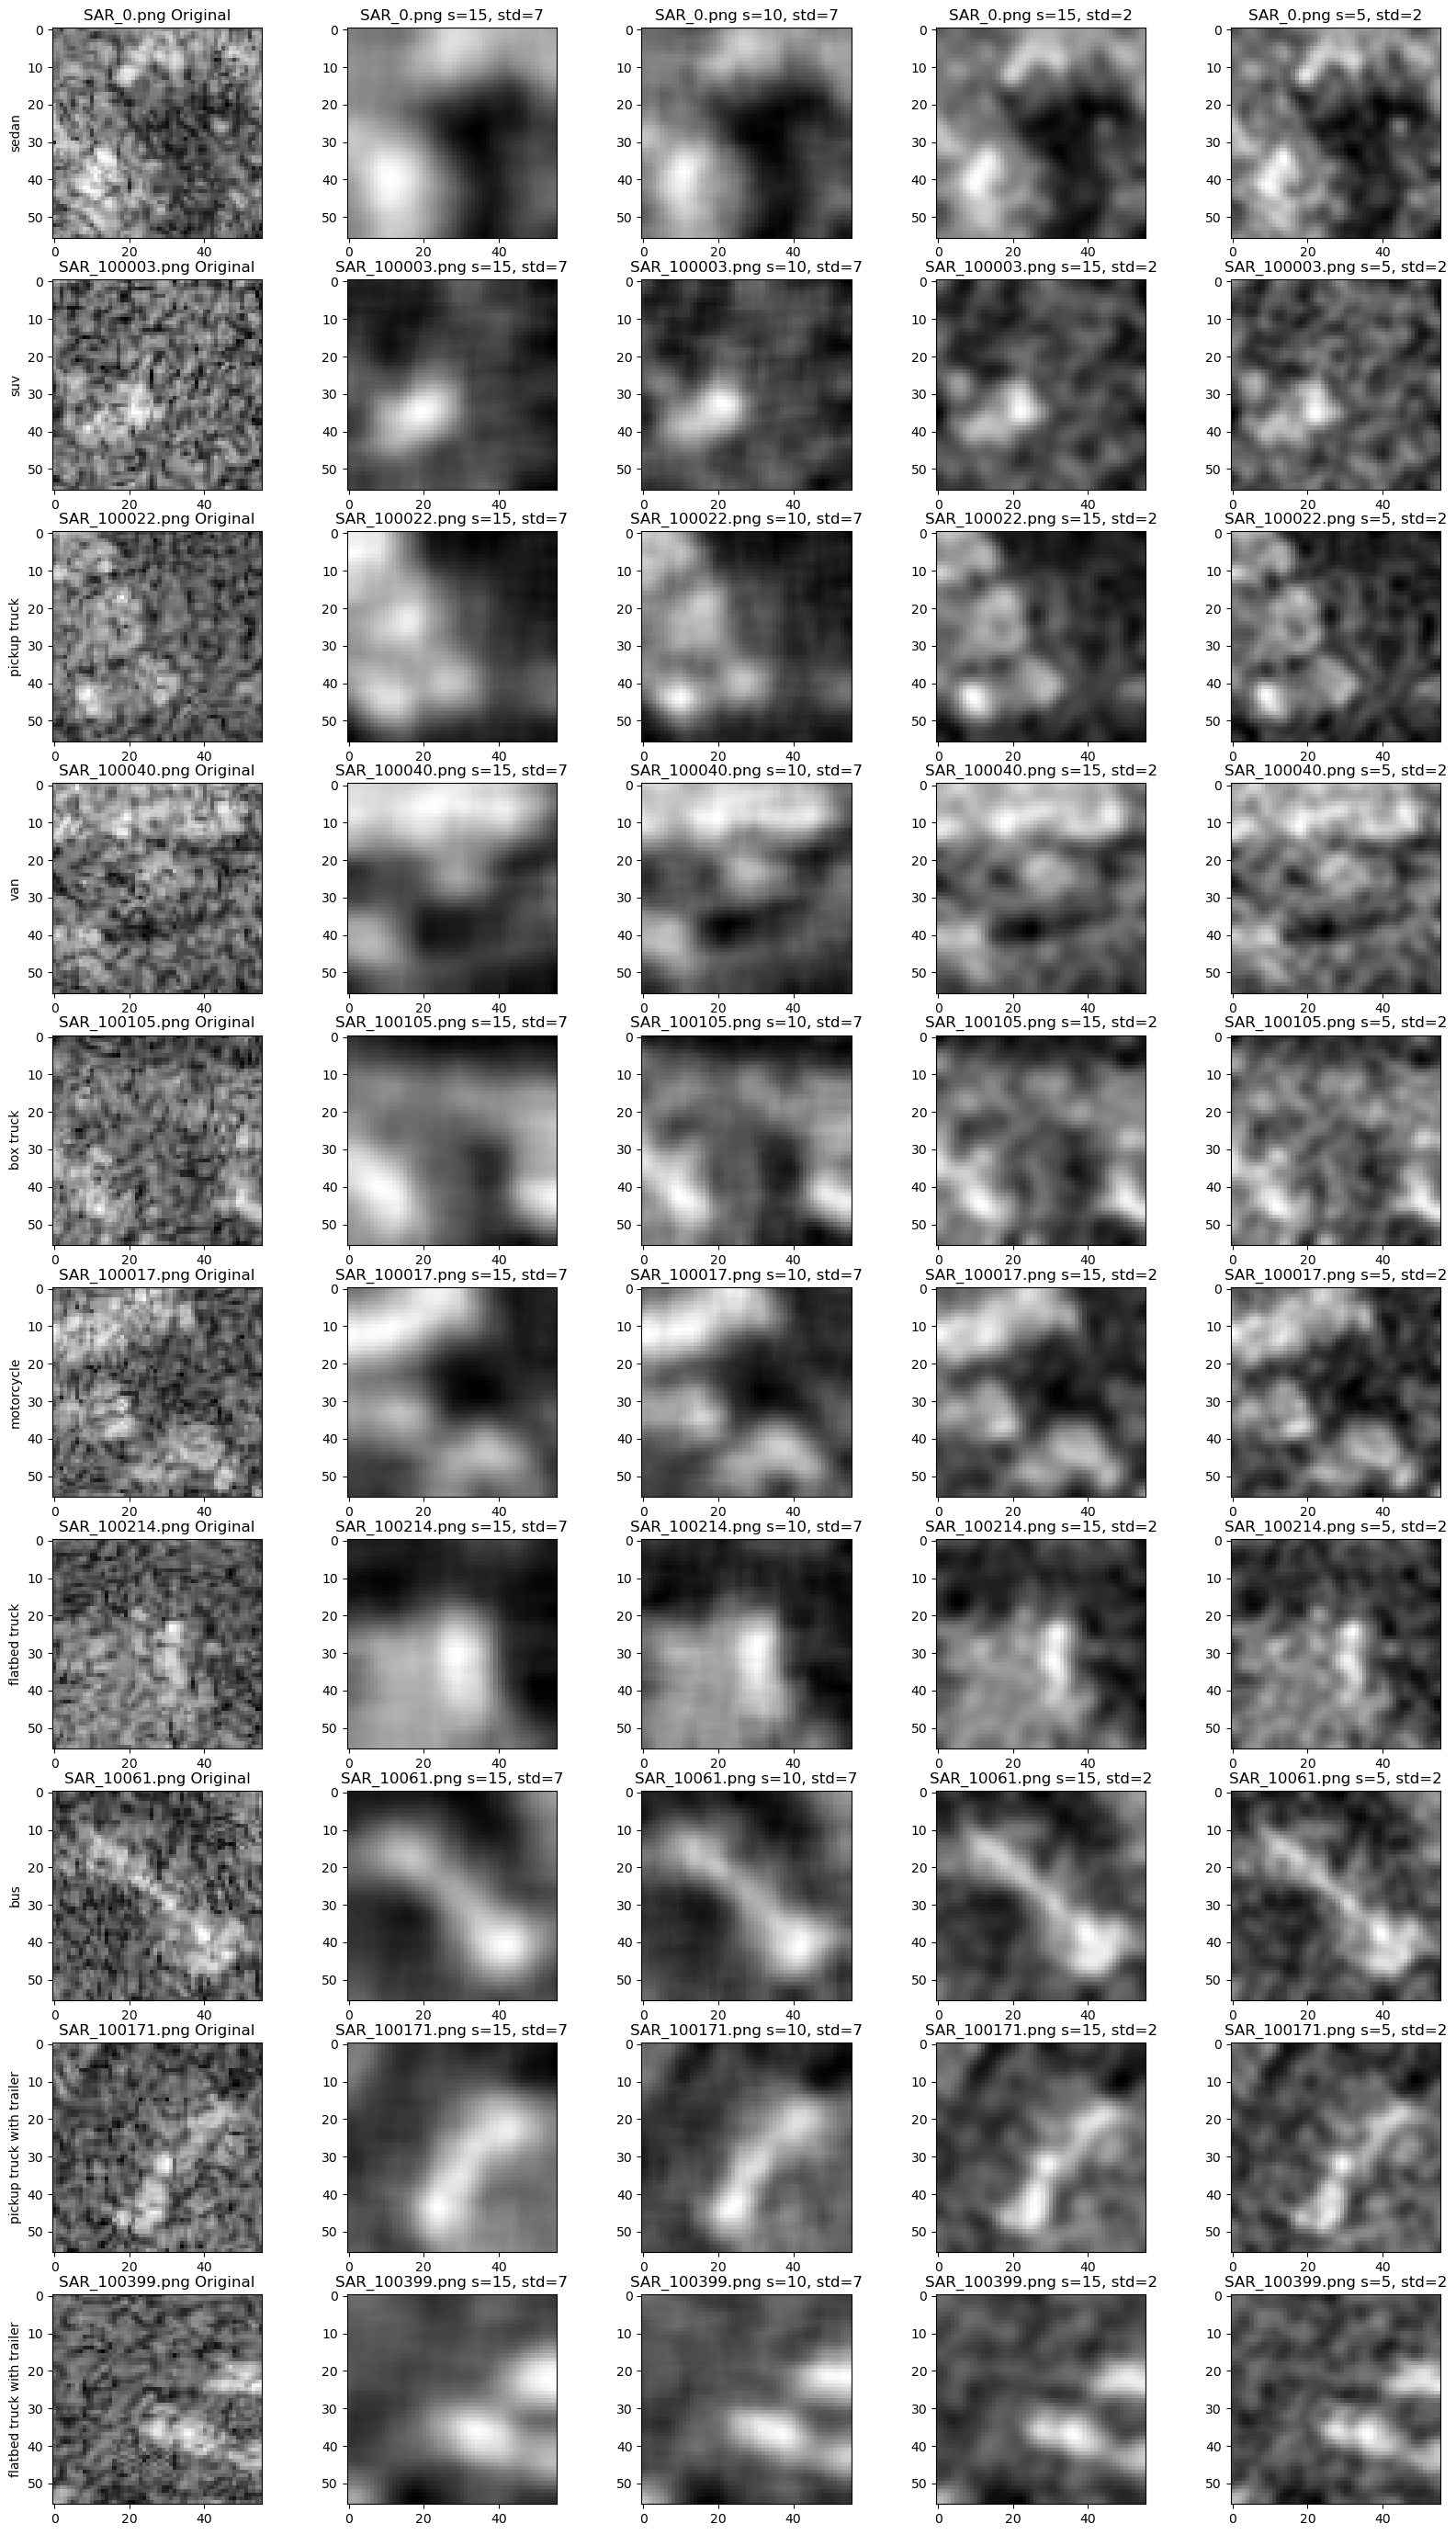

In [ ]:
# Noise Reduce SAR Images by LP Filtering

s = 1
fig, ax = plt.subplots(10, s*5, figsize=(20,35))

for i in range(10):
    # For a sample of s images
    for j in range(0,s*5,5):
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][j] 
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        img_sar_lp1 = lp_filter(img_sar, size=15, std=7)
        img_sar_lp2 = lp_filter(img_sar, size=10, std=7)
        img_sar_lp3 = lp_filter(img_sar, size=15, std=2)
        img_sar_lp4 = lp_filter(img_sar, size=5, std=2)
        
        # Displaying the images
        ax[i][j].imshow(img_sar, cmap='gray')
        ax[i][j].set_title(sar_filenames[i][j] + " Original")
        ax[i][j+1].imshow(img_sar_lp1, cmap='gray')
        ax[i][j+1].set_title(sar_filenames[i][j] + " s=15, std=7")
        ax[i][j+2].imshow(img_sar_lp2, cmap='gray')
        ax[i][j+2].set_title(sar_filenames[i][j] + " s=10, std=7")
        ax[i][j+3].imshow(img_sar_lp3, cmap='gray')
        ax[i][j+3].set_title(sar_filenames[i][j] + " s=15, std=2")
        ax[i][j+4].imshow(img_sar_lp4, cmap='gray')
        ax[i][j+4].set_title(sar_filenames[i][j] + " s=5, std=2")
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()

## Sharpening (on EO first)

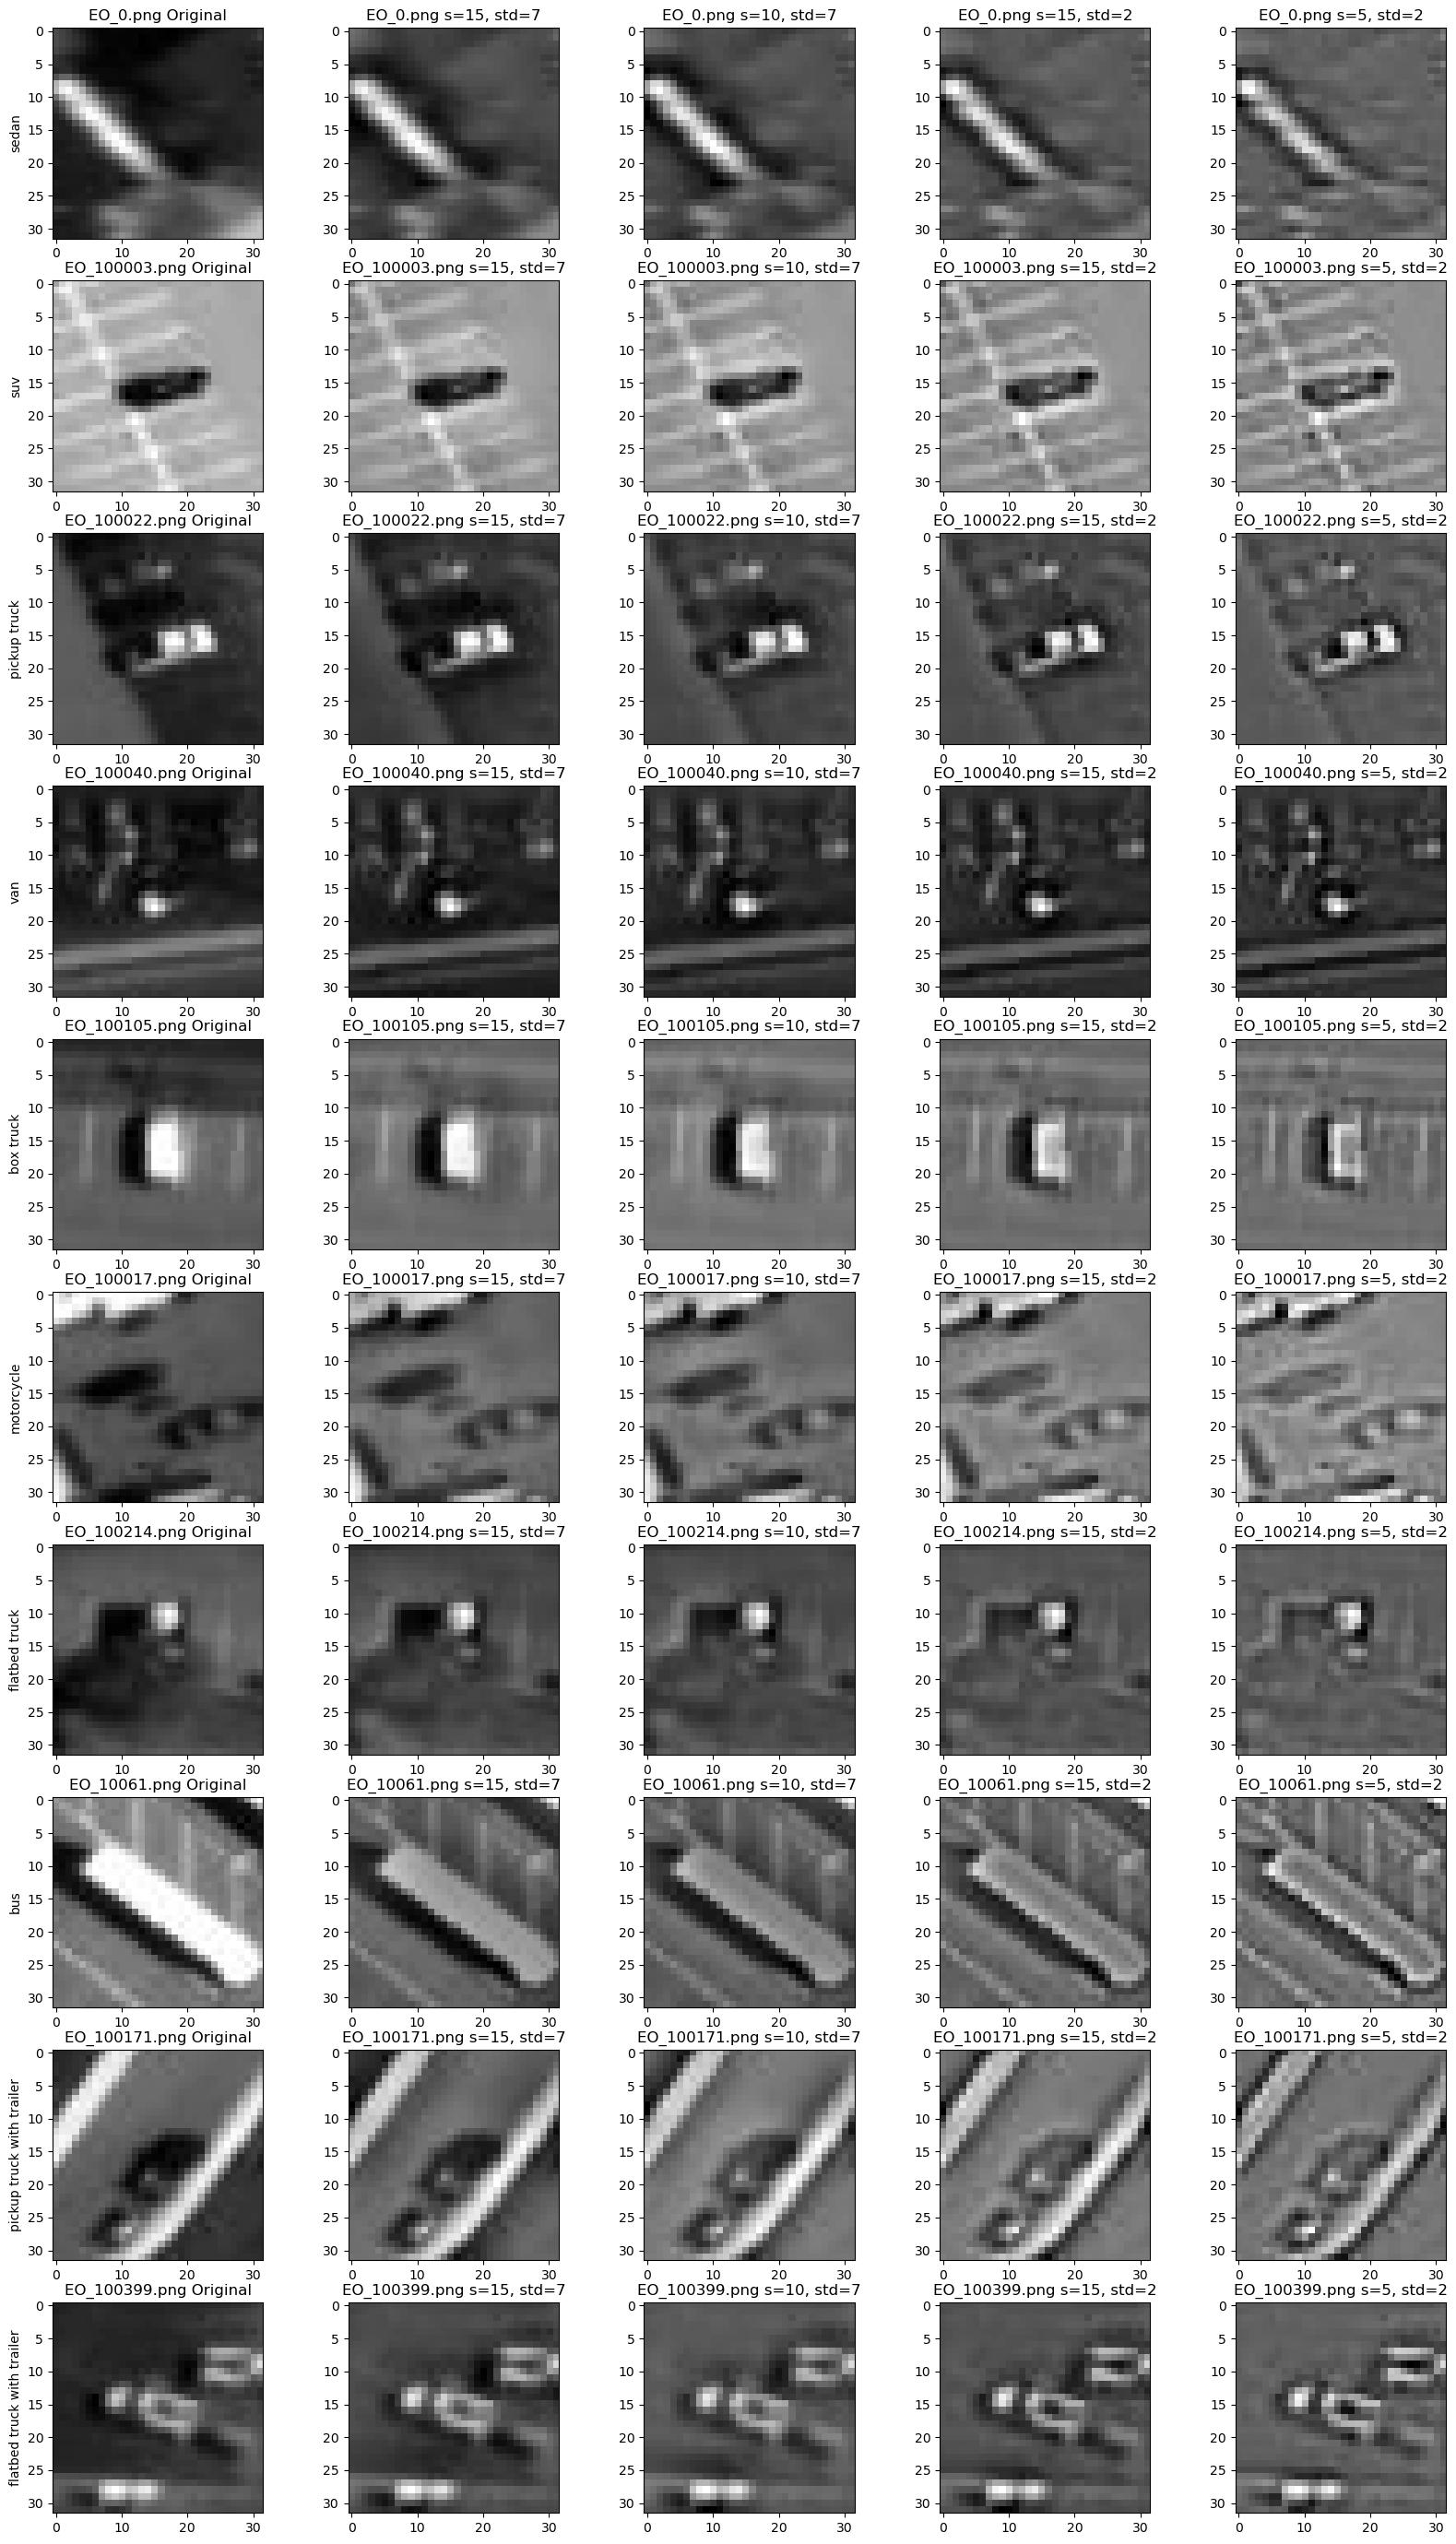

In [ ]:
# Sharpen EO Images by HP Filtering

s = 1
fig, ax = plt.subplots(10, s*5, figsize=(20,35))

for i in range(10):
    # For a sample of s images
    for j in range(0,s*5,5):
        # EO path
        path_eo = rootdir + "/" + str(i) + "/" + eo_filenames[i][j] 
        # SAR path
        path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j] 
        
        # Read images
        img_eo = plt.imread(path_eo)
        img_sar = plt.imread(path_sar)
        
        img_eo_hp1 = hp_filter(img_eo, size=15, std=7)
        img_eo_hp2 = hp_filter(img_eo, size=10, std=7)
        img_eo_hp3 = hp_filter(img_eo, size=15, std=2)
        img_eo_hp4 = hp_filter(img_eo, size=5, std=2)
        
        # Displaying the images
        ax[i][j].imshow(img_eo, cmap='gray')
        ax[i][j].set_title(eo_filenames[i][j] + " Original")
        ax[i][j+1].imshow(img_eo_hp1, cmap='gray')
        ax[i][j+1].set_title(eo_filenames[i][j] + " s=15, std=7")
        ax[i][j+2].imshow(img_eo_hp2, cmap='gray')
        ax[i][j+2].set_title(eo_filenames[i][j] + " s=10, std=7")
        ax[i][j+3].imshow(img_eo_hp3, cmap='gray')
        ax[i][j+3].set_title(eo_filenames[i][j] + " s=15, std=2")
        ax[i][j+4].imshow(img_eo_hp4, cmap='gray')
        ax[i][j+4].set_title(eo_filenames[i][j] + " s=5, std=2")
        
    ax[i][0].set_ylabel(labels[i])
    
plt.show()

## Unsharp mask filtering on SAR Images

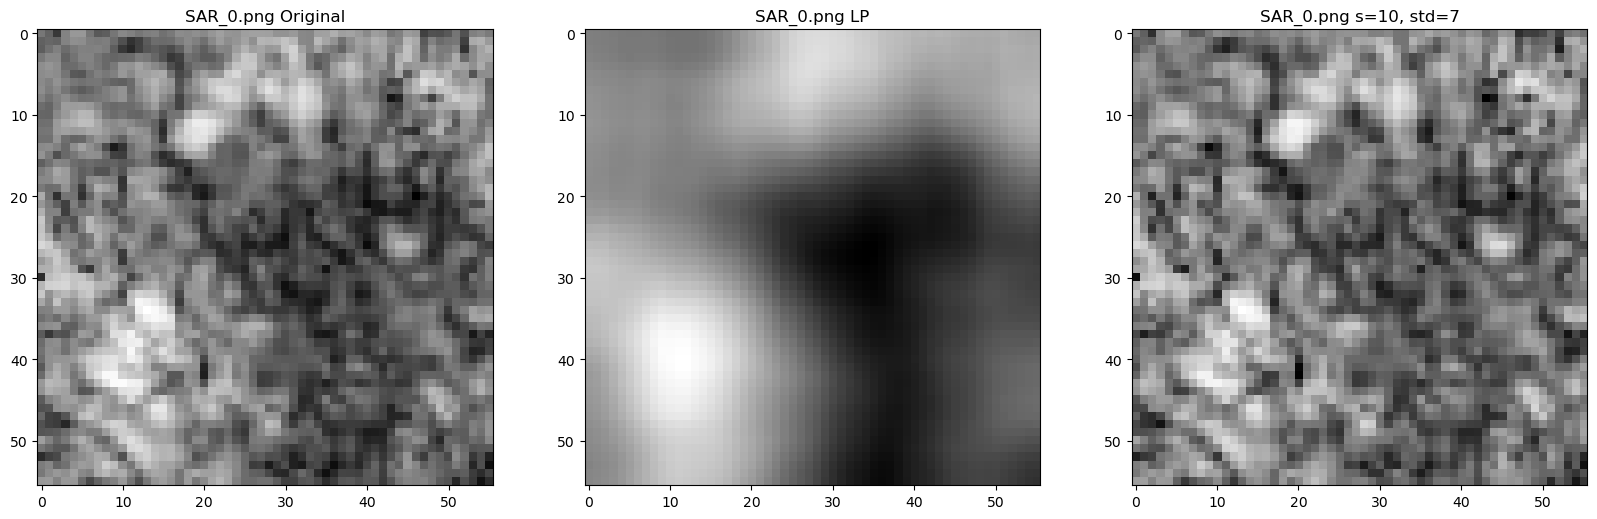

In [ ]:
# Subtract the blurred image [Ib] from original image [I], to get the high frequency image: [Ih = I - Ib]. 
# Then add the high frequency image [Ih] back to the original [I] to get the unsharp mask image: [Is = I + Ih]
# Technique taken from Assignment 3. 

path_sar = rootdir + "/0/" + sar_filenames[0][0]


# Read images
img_sar = plt.imread(path_sar)

img_sar_lp = lp_filter(img_sar, size=15, std=7)
img_unsharp_mask = (img_sar - img_sar_lp) + img_sar
img_unsharp_mask_norm = normalize_img(img_unsharp_mask)

# Displaying the images
fig, ax = plt.subplots(1, 3, figsize=(20,35))
i = 0
j = 0
ax[j].imshow(img_sar, cmap='gray')
ax[j].set_title(sar_filenames[0][0] + " Original")
ax[j+1].imshow(img_sar_lp, cmap='gray')
ax[j+1].set_title(sar_filenames[0][0] + " LP")
ax[j+2].imshow(img_unsharp_mask_norm, cmap='gray')
ax[j+2].set_title(sar_filenames[0][0] + " s=10, std=7")
# ax[i][j+3].set_title(eo_filenames[i][j] + " s=15, std=2")
# ax[i][j+4].imshow(img_eo_hp4, cmap='gray')
# ax[i][j+4].set_title(eo_filenames[i][j] + " s=5, std=2")
plt.show()

## Edge Detection (after noise reduction for SAR and sharpening for EO)
Methods to employ:
1. Canny edge detector.
2. Directional Derivatives to Gradients
3. Histogram of gradients?



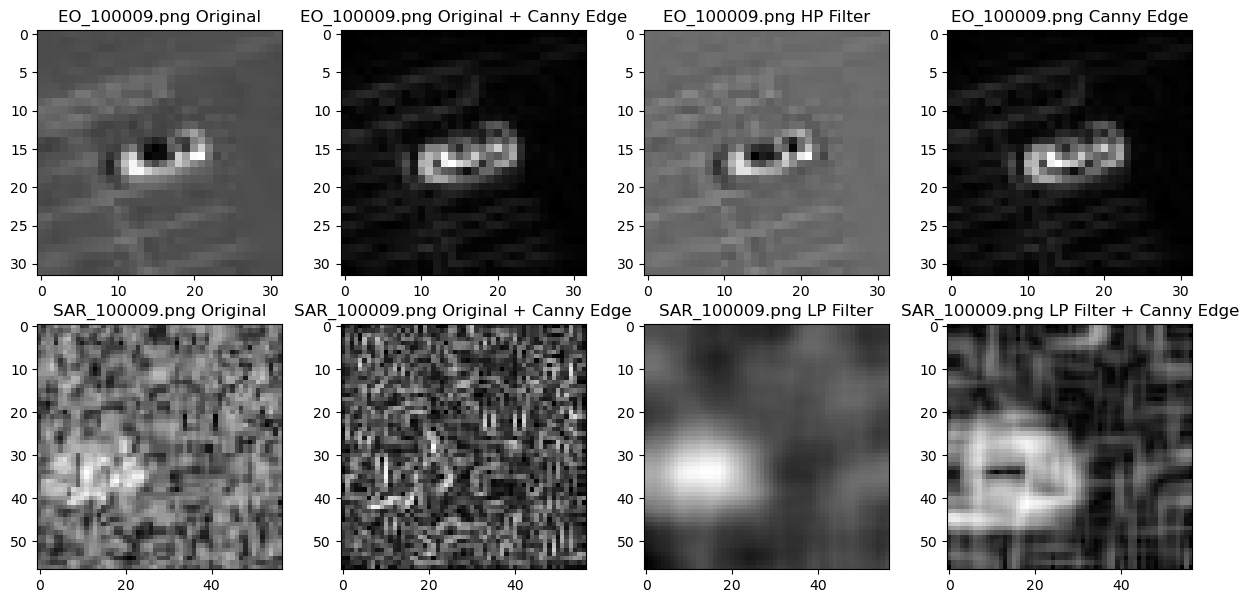

In [ ]:
# Approach taken from least squares exercise
# Set labels and image # to access
i = 0 # Folder or Label Number
j = 10 # Image Number

# Get path to images
path_eo = rootdir + "/" + str(i) + "/"  + eo_filenames[i][j]
path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j]


# Read images
img_eo = plt.imread(path_eo)
img_sar = plt.imread(path_sar)

# Put EO image through HP filter
img_eo_hp = hp_filter(img_eo, size=5, std=2)
# img_eo_hp1 = hp_filter(img_eo, size=15, std=7)
# img_eo_hp2 = hp_filter(img_eo, size=10, std=7)
# img_eo_hp3 = hp_filter(img_eo, size=15, std=2)
# img_eo_hp4 = hp_filter(img_eo, size=5, std=2)
# img_eo_hp = img_eo # use this if don't want to apply filter

# Put SAR image through LP filter
img_sar_lp = lp_filter(img_sar, size=15, std=7)
# img_sar_lp = img_sar # use this if don't want to apply filter

# Normalize images
if np.max(img_eo)>1:
    img_eo = normalize(img_eo)
    
if np.max(img_sar_lp)>1:
    img_sar_lp = normalize(img_sar_lp)
    
# Compute edges of the EO image 
# TODO: decide the ksize for extracting the edges
eo_sobelx = cv2.Sobel(img_eo,cv2.CV_32F,1,0, ksize=3) # Find x and y gradients
eo_sobely = cv2.Sobel(img_eo,cv2.CV_32F,0,1, ksize=3)
eo_magnitude = np.sqrt(eo_sobelx**2.0 + eo_sobely**2.0)
eo_magnitude = eo_magnitude/np.max(eo_magnitude) # normalize

# Compute edges of the EO image + HP Filter
# TODO: decide the ksize for extracting the edges
eo_hp_sobelx = cv2.Sobel(img_eo_hp,cv2.CV_32F,1,0, ksize=3) # Find x and y gradients
eo_hp_sobely = cv2.Sobel(img_eo_hp,cv2.CV_32F,0,1, ksize=3)
eo_hp_magnitude = np.sqrt(eo_hp_sobelx**2.0 + eo_hp_sobely**2.0)
eo_hp_magnitude = eo_hp_magnitude/np.max(eo_hp_magnitude) # normalize
    
# Compute edges of the SAR image 
# TODO: decide the ksize for extracting the edges
sar_sobelx = cv2.Sobel(img_sar,cv2.CV_32F,1,0, ksize=3) # Find x and y gradients
sar_sobely = cv2.Sobel(img_sar,cv2.CV_32F,0,1, ksize=3)
sar_magnitude = np.sqrt(sar_sobelx**2.0 + sar_sobely**2.0)
sar_magnitude = sar_magnitude/np.max(sar_magnitude) # normalize

# Compute edges of the SAR image + LP Filter
# TODO: decide the ksize for extracting the edges
sar_lp_sobelx = cv2.Sobel(img_sar_lp,cv2.CV_32F,1,0, ksize=3) # Find x and y gradients
sar_lp_sobely = cv2.Sobel(img_sar_lp,cv2.CV_32F,0,1, ksize=3)
sar_lp_magnitude = np.sqrt(sar_lp_sobelx**2.0 + sar_lp_sobely**2.0)
sar_lp_magnitude = sar_lp_magnitude/np.max(sar_lp_magnitude) # normalize


# Display Plots
# EO
fig, ax = plt.subplots(2, 4, figsize=(15,7))
ax[0][0].imshow(img_eo, cmap='gray')
ax[0][0].set_title(eo_filenames[i][j] + " Original")
ax[0][1].imshow(eo_magnitude, cmap='gray')
ax[0][1].set_title(eo_filenames[i][j] + " Original + Canny Edge")
ax[0][2].imshow(img_eo_hp, cmap='gray')
ax[0][2].set_title(eo_filenames[i][j] + " HP Filter")
ax[0][3].imshow(eo_magnitude, cmap='gray')
ax[0][3].set_title(eo_filenames[i][j] + " Canny Edge")
# SAR
ax[1][0].imshow(img_sar, cmap='gray')
ax[1][0].set_title(sar_filenames[i][j] + " Original")
ax[1][1].imshow(sar_magnitude, cmap='gray')
ax[1][1].set_title(sar_filenames[i][j] + " Original + Canny Edge")
ax[1][2].imshow(img_sar_lp, cmap='gray')
ax[1][2].set_title(sar_filenames[i][j] + " LP Filter")
ax[1][3].imshow(sar_lp_magnitude, cmap='gray')
ax[1][3].set_title(sar_filenames[i][j] + " LP Filter + Canny Edge")


# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im_ax, cax=cax)
plt.show()


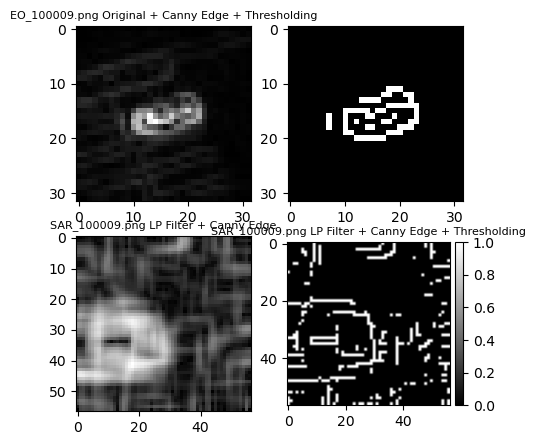

In [ ]:
# Threshold the image for the EO original image (no HP filter) + Canny Edge and the SAR LP filtered + Canny Edge


eo_magnitude = eo_magnitude
eo_magnitude = eo_magnitude/np.max(eo_magnitude) # normalize

eo_im_threshold = cv2.Canny(image=(eo_magnitude*255).astype(np.uint8), threshold1=200, threshold2=255) # Canny Edge 
eo_im_threshold = eo_im_threshold / np.max(eo_im_threshold) # normalize


sar_magnitude = sar_lp_magnitude
sar_magnitude = sar_magnitude/np.max(sar_magnitude) # normalize

sar_im_threshold = cv2.Canny(image=(sar_magnitude*255).astype(np.uint8), threshold1=250, threshold2=255) # Canny Edge 
sar_im_threshold = sar_im_threshold / np.max(sar_im_threshold) # normalize

# Display Plots
# EO

fig, ax = plt.subplots(2, 2, figsize=(5,5))

ax[0][0].imshow(eo_magnitude, cmap='gray')
ax[0][0].set_title(eo_filenames[i][j] + " Original + Canny Edge", fontsize=8)
im0 = ax[0][1].imshow(eo_im_threshold, cmap='gray')
ax[0][0].set_title(eo_filenames[i][j] + " Original + Canny Edge + Thresholding", fontsize=8)
# SAR
ax[1][0].imshow(sar_lp_magnitude, cmap='gray')
ax[1][0].set_title(sar_filenames[i][j] + " LP Filter + Canny Edge", fontsize=8)
im1 = ax[1][1].imshow(sar_im_threshold, cmap='gray')
ax[1][1].set_title(sar_filenames[i][j] + " LP Filter + Canny Edge + Thresholding", fontsize=8)
divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im0, ax = ax[0][1], cax=cax)
plt.colorbar(im1, ax = ax[1][1], cax=cax)
plt.show()

# display the points
# fig, ax = plt.subplots(figsize=(5,5))
# im_ax = plt.imshow(eo_im_threshold, cmap='gray')
# # create an axes on the right side of ax. The width of cax will be 5%
# # of ax and the padding between cax and ax will be fixed at 0.05 inch.

# plt.colorbar(im_ax, cax=cax)
# plt.show()


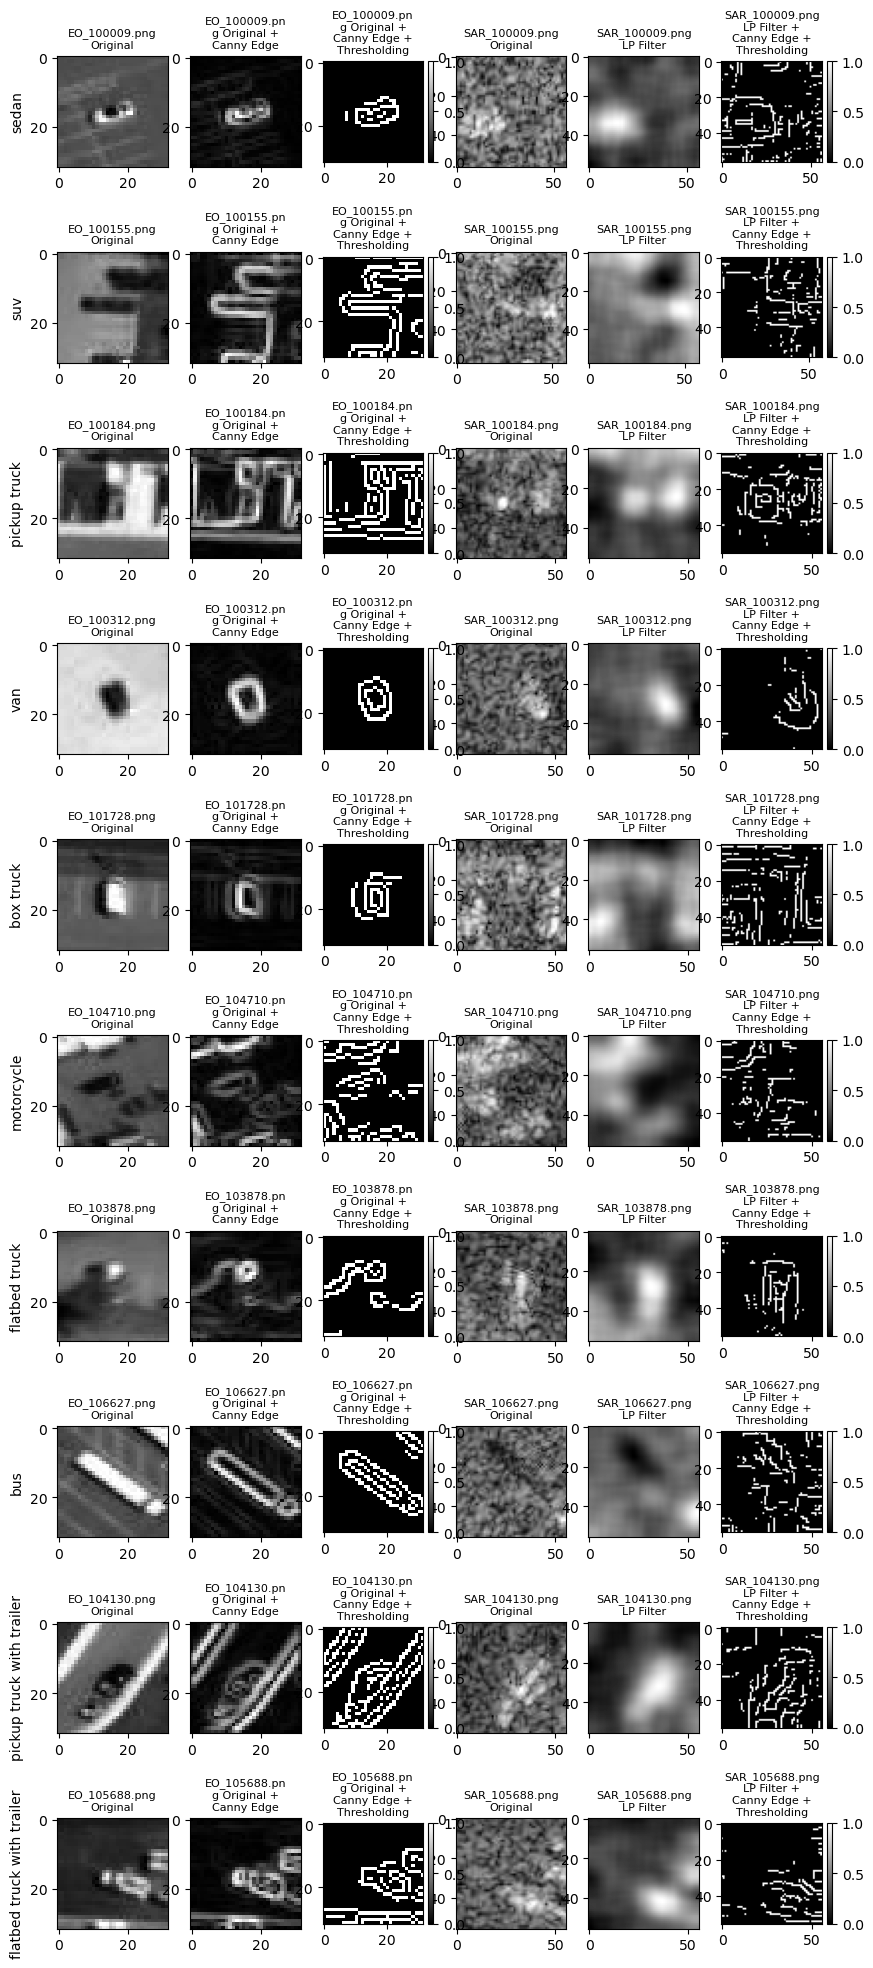

In [ ]:
# Approach taken from least squares exercise
# Set labels and image # to access

# Display Plots
fig, ax = plt.subplots(10, 6, figsize=(10,25))

# Initialize eo and sar thresholding images and filenames to save for later
eo_im_thresholds = []
eo_im_filenames = []
sar_im_thresholds = []
sar_im_filenames = []

for i in range(10): # Folder or Label Number
    j = 10 # Image Number (randomnly chosen - can change to a loop if want to include more images)

    # Get path to images
    eo_im_filenames.append(eo_filenames[i][j])
    sar_im_filenames.append(sar_filenames[i][j])
    path_eo = rootdir + "/" + str(i) + "/"  + eo_filenames[i][j]
    path_sar = rootdir + "/" + str(i) + "/" + sar_filenames[i][j]

    # Read images
    img_eo = plt.imread(path_eo)
    img_sar = plt.imread(path_sar)

    # Put SAR image through LP filter
    img_sar_lp = lp_filter(img_sar, size=15, std=7)
    

    # Normalize images
    if np.max(img_eo)>1:
        img_eo = normalize(img_eo)

    if np.max(img_sar_lp)>1:
        img_sar_lp = normalize(img_sar_lp)
    
    # Compute edges of the EO image 
    # TODO: decide the ksize for extracting the edges
    eo_sobelx = cv2.Sobel(img_eo,cv2.CV_32F,1,0, ksize=3) # Find x and y gradients
    eo_sobely = cv2.Sobel(img_eo,cv2.CV_32F,0,1, ksize=3)
    eo_magnitude = np.sqrt(eo_sobelx**2.0 + eo_sobely**2.0)
    eo_magnitude = eo_magnitude/np.max(eo_magnitude) # normalize
    
    # Compute EO thresholds
    eo_im_threshold = cv2.Canny(image=(eo_magnitude*255).astype(np.uint8), threshold1=200, threshold2=255) # Canny Edge 
    eo_im_threshold = eo_im_threshold / np.max(eo_im_threshold) # normalize
    eo_im_thresholds.append(eo_im_threshold)
    
    # Compute edges of the SAR image + LP Filter
    # TODO: decide the ksize for extracting the edges
    sar_lp_sobelx = cv2.Sobel(img_sar_lp,cv2.CV_32F,1,0, ksize=3) # Find x and y gradients
    sar_lp_sobely = cv2.Sobel(img_sar_lp,cv2.CV_32F,0,1, ksize=3)
    sar_lp_magnitude = np.sqrt(sar_lp_sobelx**2.0 + sar_lp_sobely**2.0)
    sar_lp_magnitude = sar_lp_magnitude/np.max(sar_lp_magnitude) # normalize
    
    # Compute SAR thresholds
    sar_im_threshold = cv2.Canny(image=(sar_lp_magnitude*255).astype(np.uint8), threshold1=250, threshold2=255) # Canny Edge 
    sar_im_threshold = sar_im_threshold / np.max(sar_im_threshold) # normalize
    sar_im_thresholds.append(sar_im_threshold)

    # Plot EO
    ax[i][0].imshow(img_eo, cmap='gray')
    ax[i][0].set_title('\n'.join(wrap(eo_filenames[i][j] + " Original",15)), fontsize=8)
    ax[i][1].imshow(eo_magnitude, cmap='gray')
    ax[i][1].set_title('\n'.join(wrap(eo_filenames[i][j] + " Original + Canny Edge",12)), fontsize=8)
    ax[i][2].set_title('\n'.join(wrap(eo_filenames[i][j] + " Original + Canny Edge + Thresholding",12)), fontsize=8)
    im0 = ax[i][2].imshow(eo_im_threshold, cmap='gray')
    divider = make_axes_locatable(ax[i][2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im0, ax = ax[i][2], cax=cax)

    # Plot SAR
    ax[i][3].imshow(img_sar, cmap='gray')
    ax[i][3].set_title('\n'.join(wrap(sar_filenames[i][j] + " Original",15)), fontsize=8)
    ax[i][4].imshow(img_sar_lp, cmap='gray')
    ax[i][4].set_title(sar_filenames[i][j] + " LP Filter", fontsize=8)
    ax[i][4].set_title('\n'.join(wrap(sar_filenames[i][j] + " LP Filter",15)), fontsize=8)
    ax[i][5].set_title('\n'.join(wrap(sar_filenames[i][j] + " LP Filter + Canny Edge + Thresholding",15)), fontsize=8)
    im1 = ax[i][5].imshow(sar_im_threshold, cmap='gray')
    divider = make_axes_locatable(ax[i][5])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, ax = ax[i][5], cax=cax)
    
    # Set label name for each row
    ax[i][0].set_ylabel(labels[i])

plt.show()


Notes:
* SAR and EO images not fully aligned.

Next steps: Use rectangle or shape detection on the sample thresholded images stored in eo_im_thresholds and sar_im_thresholds, with the filenames eo_im_filenames and sar_im_filenames.

In [ ]:
eo_im_filenames

['EO_100009.png',
 'EO_100155.png',
 'EO_100184.png',
 'EO_100312.png',
 'EO_101728.png',
 'EO_104710.png',
 'EO_103878.png',
 'EO_106627.png',
 'EO_104130.png',
 'EO_105688.png']

In [ ]:
sar_im_filenames

['SAR_100009.png',
 'SAR_100155.png',
 'SAR_100184.png',
 'SAR_100312.png',
 'SAR_101728.png',
 'SAR_104710.png',
 'SAR_103878.png',
 'SAR_106627.png',
 'SAR_104130.png',
 'SAR_105688.png']

In [ ]:
#compute space-time derivatives
img_path = 'C:/Users/shirl/Documents/Documents/UCB/W281/Final project/EO_145726.png'
img = plt.imread(img_path)
p = [0.030320, 0.249724, 0.439911, 0.249724, 0.030320]
d = [-0.104550, -0.292315, 0.0, 0.292315, 0.104550]
img_x = sepfir2d(img, d, p)
img_y = sepfir2d(img, p, d)

In [ ]:
# Display original image
img = cv2.imread(img_path)
cv2.imshow('Original', img)
cv2.waitKey(0)

-1

In [ ]:
# Convert to graycsale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
# Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection

In [ ]:
cv2.imshow('Sobel X', sobelx)
cv2.waitKey(0)
cv2.imshow('S0obel Y', sobely)
cv2.waitKey(0)
cv2.imshow('Sobel X Y using Sobel() function', sobelxy)
cv2.waitKey(0)
# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
# Display Canny Edge Detection Image
cv2.imshow('Canny Edge Detection', edges)
cv2.waitKey(0)
cv2.imwrite('C:/Users/shirl/Documents/Documents/UCB/W281/Final project/EO_145726_edge.png', edges)
cv2.imshow('Edge image', cv2.imread('C:/Users/shirl/Documents/Documents/UCB/W281/Final project/EO_145726_edge.png'))
cv2.waitKey(0)

-1

## Rectangle Detection
https://www.delftstack.com/howto/python/opencv-detect-rectangle/#:~:text=Use%20the%20findContours()%20and,rectangles%20according%20to%20their%20area.

In [6]:
from google.colab.patches import cv2_imshow

0.0
0.0
557.0
2.0


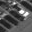

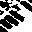

In [8]:
img = cv2.imread('/content/EO_1839.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for cnt in cnts:
    approx = cv2.contourArea(cnt)
    print(approx)

cv2_imshow(img)
cv2_imshow(thresh_img)

## Shape Detection
https://www.geeksforgeeks.org/how-to-detect-shapes-in-images-in-python-using-opencv/

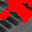

In [9]:
img = cv2.imread('/content/EO_1839.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# setting threshold of gray image
_, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# using a findContours() function
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
i = 0

# list for storing names of shapes
for contour in contours:

    # here we are ignoring first counter because
    # findcontour function detects whole image as shape
    if i == 0:
        i = 1
        continue

    # cv2.approxPloyDP() function to approximate the shape
    approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)

    # using drawContours() function
    cv2.drawContours(img, [contour], 0, (0, 0, 255), 5)

    # finding center point of shape
    M = cv2.moments(contour)
    if M['m00'] != 0.0:
        x = int(M['m10']/M['m00'])
        y = int(M['m01']/M['m00'])

    # putting shape name at center of each shape
    # if len(approx) == 3:
    #     cv2.putText(img, 'Triangle', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.1, (255, 255, 255), 2)

    # elif len(approx) == 4:
    #     cv2.putText(img, 'Quadrilateral', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.1, (255, 255, 255), 2)

    # elif len(approx) == 5:
    #     cv2.putText(img, 'Pentagon', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.1, (255, 255, 255), 2)

    # elif len(approx) == 6:
    #     cv2.putText(img, 'Hexagon', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.1, (255, 255, 255), 2)

    # else:
    #     cv2.putText(img, 'circle', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.1, (255, 255, 255), 2)

# displaying the image after drawing contours
cv2_imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()